#### <font color='DarkBlue'>Работа выполнена на версии python 3.7.3</font>

#### Версии используемых библиотек:
1. numpy 1.16.4
2. pandas 0.25.0
3. matplotlib 3.1.1
4. seaborn 0.9.0
5. sklearn 0.21.2

# Курсовой проект по курсу "Python для Data Science"

**Материалы к проекту (файлы):**
train.csv, 
test.csv

**Задание:**
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать цены для квартир из файла test.csv.

**Целевая переменная:**
Price

**Основная метрика:**
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Вспомогательная метрика:**
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

**Сдача проекта:**
1. Прислать в раздел "Задания" урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb).
2. Приложить файл с названием по образцу PNagornyi_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

**Сроки сдачи:**
Сдать проект за 72 часа после урока 10 ("Вебинар. Консультация по итоговому проекту").

**Примечание:**
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

## Шаг 0: Подготовка инструментов

### 0.1 Необходимые модули

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression as LR, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import r2_score as r2,mean_squared_error as MSE
from sklearn.cluster import KMeans, AgglomerativeClustering
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

### 0.2 Загрузка данных

Загрузим тренировочные данные в переменную **train_data**, тестовые данные в переменную **test_data**

In [2]:
train_data_base=pd.read_csv('train.csv')
train_data=train_data_base.copy()
train_data.shape

(10000, 20)

In [3]:
test_data_base=pd.read_csv('test.csv')
test_data=test_data_base.copy()
test_data.shape

(5000, 19)

### 0.3 Необходимые функции

In [4]:
def plot_boxplot(title, train_data, test_data):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.box(True)
    plt.grid()
    my_pal = {'Train': 'LightGreen', 'Test': 'LightYellow'}
    df = pd.DataFrame({'Train' : train_data, 'Test' : test_data})
    sns.boxplot(x='value', y='variable', data=pd.melt(df), palette=my_pal)
    plt.show()

In [5]:
def plot_hist(title, train_data, test_data):
    plt.figure(figsize=(10,5))
    plt.xlabel(title)
    plt.grid()
    plt.hist(train_data, bins=15, density=False, label='Train', alpha=0.5, color='green')
    plt.hist(test_data, bins=15, density=False, label='Test', alpha=0.5, color='yellow')
    plt.legend()
    plt.show()

In [6]:
def plot_scatter(title, data, x, y, color='b'):
    pd_scatter_plot = data.plot(y=y, x=x, kind='scatter', title=title, color=color)
    pd_scatter_plot.set_xlabel(x)
    pd_scatter_plot.set_ylabel(y)

In [7]:
def join_stats1(df,stats1,source_df,mode='train'):
    df=pd.merge(df,stats1,on=['DistrictId','Rooms'],how='left')
    if mode=='test':
        df['Price_per_meter']=df['Price_per_meter'].fillna(source_df['Price_per_meter'].mean())
    return df

In [8]:
def smart_cat_encode(df):
    data = df.copy()
    feat_list = list(data.columns)
    for feature in feat_list:
        if feature != 'Id':
            newfeature = feature + '_size'
            data[newfeature] = data[feature].map(data.groupby(feature).size())
            data = data.drop(feature, axis=1)
    return data

In [9]:
def add_string_to_df(df, string):
    data = df.copy()
    data.loc[len(data)] = string
    return data

## Шаг 1: Подготовка данных

### 1.1 Обработка выбросов

In [10]:
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [11]:
test_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [12]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [13]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,3959.0,36.158810,17.825287,0.333490,23.092026,32.925087,45.174091,303.071094
KitchenSquare,5000.0,5.976800,9.950018,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


#### 1.1.1 DistrictId

Посмотрим на признак 'DistrictId'. Выясним, есть ли прямая зависимость цены от этого признака.

Построим диаграмму рассеивания:

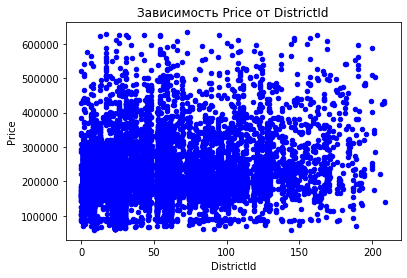

In [14]:
plot_scatter('Зависимость Price от DistrictId', train_data, 'DistrictId', 'Price','b')

Видим, что прямой зависимости от этого признака нет.

Данный признак категориальный, поэтому преобразуем тип данных в нем:

In [15]:
train_data['DistrictId']=train_data['DistrictId'].astype(object)
test_data['DistrictId']=test_data['DistrictId'].astype(object)

#### 1.1.2 Rooms

Теперь посмотрим на признак 'Rooms'.

In [16]:
train_data['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [17]:
test_data['Rooms'].describe()

count    5000.000000
mean        1.910000
std         0.838594
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        17.000000
Name: Rooms, dtype: float64

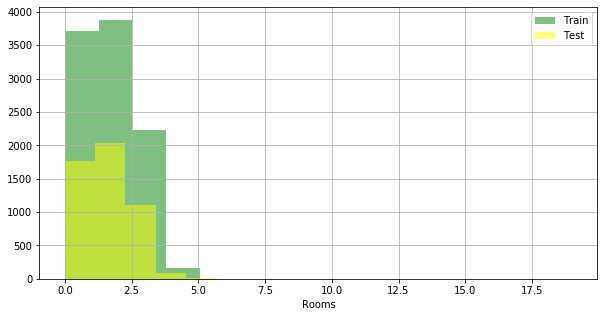

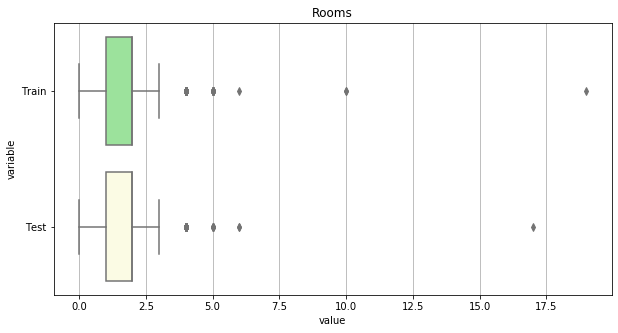

In [18]:
plot_hist('Rooms', train_data['Rooms'], test_data['Rooms'])
plot_boxplot('Rooms', train_data['Rooms'], test_data['Rooms'])

Видим, что есть 'хвост', посмотрим на него:

In [19]:
train_data.loc[train_data['Rooms']>=5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1422,4282,195,5.0,95.617533,62.377052,7.0,7,7.0,1940,0.015017,B,B,17,3079,59,2890.0,0,8,B,479525.147323
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
1503,1243,86,5.0,108.057398,82.723825,8.0,3,5.0,1942,0.161976,B,A,31,7010,5,4508.0,3,7,B,310305.074733
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
3268,8901,34,5.0,121.577423,114.913843,1.0,25,1.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,455446.393758
3271,6358,27,5.0,42.003293,NaN,0.0,5,12.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,112693.641769
4431,7594,53,5.0,39.906082,39.394024,1.0,5,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,206148.845716
4487,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B,622888.825328


In [20]:
train_data.loc[train_data['Rooms']==19,'Rooms']=1
train_data.loc[train_data['Rooms']==10,'Rooms']=2
train_data.loc[train_data['Id']==14003,'Rooms']=1
train_data.loc[train_data['Id']==7594,'Rooms']=1
train_data.loc[train_data['Id']==6358,'Rooms']=1

In [21]:
test_data.loc[test_data['Rooms']>=5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
78,6553,34,5.0,122.375273,0.333490,0.0,9,0.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B
619,15858,9,5.0,97.537815,63.571997,8.0,5,14.0,1995,0.136244,B,B,11,2370,0,NaN,0,1,B
803,3747,23,5.0,139.045763,89.790274,42.0,1,3.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B
1040,13562,78,5.0,116.656955,69.561006,10.0,5,14.0,2001,0.219006,B,B,28,6746,3,NaN,1,4,B
2071,10793,23,6.0,110.750226,NaN,0.0,2,2.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B
3217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
3253,12316,183,5.0,157.976101,101.040485,12.0,7,8.0,1908,0.246624,B,B,14,2940,45,NaN,3,6,B
3339,8638,25,5.0,120.330727,115.328430,1.0,14,25.0,2016,0.069753,B,B,53,13670,4,NaN,1,11,B
3398,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B
3912,6060,53,5.0,56.600162,2.742068,1.0,6,18.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B


In [22]:
test_data.loc[test_data['Rooms']==17,'Rooms']=2

In [23]:
train_data['Rooms'].value_counts()

2.0    3882
1.0    3709
3.0    2235
4.0     150
5.0      16
0.0       8
Name: Rooms, dtype: int64

In [24]:
test_data['Rooms'].value_counts()

2.0    2031
1.0    1769
3.0    1099
4.0      90
5.0       7
0.0       2
6.0       2
Name: Rooms, dtype: int64

Наблюдения, где признак "Rooms" равен 0, считаем студиями с 1 комнатой:

In [25]:
train_data.loc[train_data['Rooms']==0,'Rooms']=1
test_data.loc[test_data['Rooms']==0,'Rooms']=1

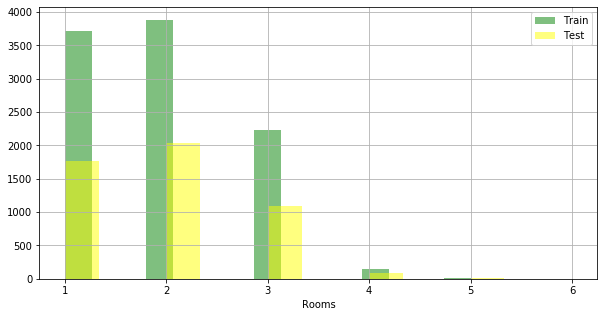

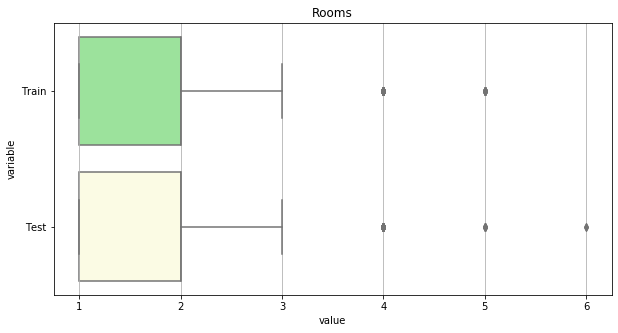

In [26]:
plot_hist('Rooms', train_data['Rooms'], test_data['Rooms'])
plot_boxplot('Rooms', train_data['Rooms'], test_data['Rooms'])

#### 1.1.3 Square и LifeSquare

Посмотрим на признак 'Square'.

In [27]:
train_data['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [28]:
test_data['Square'].describe()

count    5000.000000
mean       56.449500
std        19.092787
min         1.378543
25%        41.906231
50%        52.921340
75%        66.285129
max       223.453689
Name: Square, dtype: float64

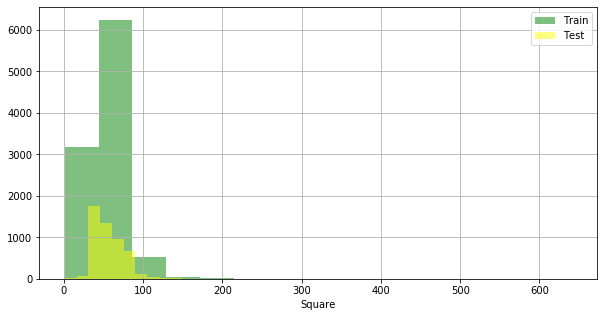

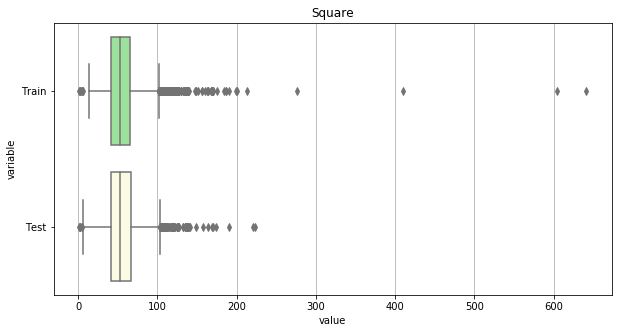

In [29]:
plot_hist('Square', train_data['Square'], test_data['Square'])
plot_boxplot('Square', train_data['Square'], test_data['Square'])

In [30]:
train_data.loc[train_data['Square']>200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1981,7917,27,1.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
9910,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016


In [31]:
train_data.loc[train_data['Id']==28,'Square']=train_data.loc[train_data['Id']==28,'Square'] / 10.0
train_data.loc[train_data['Id']==2307,'Square']=train_data.loc[train_data['Id']==2307,'Square'] / 10.0
train_data.loc[train_data['Id']==11602,'Square']=train_data.loc[train_data['Id']==11602,'Square'] / 10.0

In [32]:
test_data.loc[test_data['Square']>200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
3909,1397,76,3.0,221.138768,118.055342,4.0,32,48.0,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B


In [33]:
train_data['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [34]:
test_data['LifeSquare'].describe()

count    3959.000000
mean       36.158810
std        17.825287
min         0.333490
25%        23.092026
50%        32.925087
75%        45.174091
max       303.071094
Name: LifeSquare, dtype: float64

Выберем строки, где жилая площать больше общей площади более, чем на 5:

In [35]:
train_data.loc[train_data['LifeSquare']>train_data['Square'] + 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
590,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.231857
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366
4638,4071,6,3.0,75.203314,82.486992,1.0,13,25.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B,211324.917957
4690,2307,102,1.0,40.942518,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6332,8961,27,1.0,33.398983,164.153360,6.0,3,5.0,1965,0.211401,B,B,9,1892,0,NaN,0,1,B,104891.073757
6977,11602,30,2.0,64.106519,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8437,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978


In [36]:
train_data.loc[train_data['Id']==1748,'Square']=train_data.loc[train_data['Id']==1748,'LifeSquare']
train_data.loc[train_data['Id']==14990,'LifeSquare']=train_data.loc[train_data['Id']==590,'LifeSquare'] / 10.0
train_data.loc[train_data['Id']==10527,'Square']=train_data.loc[train_data['Id']==10527,'Square'] * 10.0
train_data.loc[train_data['Id']==16550,'LifeSquare']=train_data.loc[train_data['Id']==16550,'LifeSquare'] / 100.0
train_data.loc[train_data['Id']==4071,'Square']=train_data.loc[train_data['Id']==4071,'LifeSquare']
train_data.loc[train_data['Id']==2307,'LifeSquare']=train_data.loc[train_data['Id']==2307,'Square']
train_data.loc[train_data['Id']==8961,'LifeSquare']=train_data.loc[train_data['Id']==8961,'LifeSquare'] / 10.0
train_data.loc[train_data['Id']==13265,'Square']=train_data.loc[train_data['Id']==13265,'LifeSquare']
train_data.loc[train_data['Id']==15886,'LifeSquare']=train_data.loc[train_data['Id']==13265,'LifeSquare'] / 10.0
train_data.loc[train_data['Id']==11602,'LifeSquare']=train_data.loc[train_data['Id']==11602,'Square']

In [37]:
test_data.loc[test_data['LifeSquare']>test_data['Square'] + 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
410,11533,94,2.0,48.713443,303.071094,6.0,5,12.0,1974,0.521867,B,B,25,6149,0,NaN,0,0,B
4713,170,6,2.0,2.900586,61.468563,1.0,18,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B


In [38]:
test_data.loc[test_data['Id']==11533,'LifeSquare']=test_data.loc[test_data['Id']==11533,'Square']
test_data.loc[test_data['Id']==170,'Square']=test_data.loc[test_data['Id']==170,'LifeSquare']

Исправили совсем кривые данные с признаками 'Square' и 'LifeSquare'.

Рассмотрим строки с общей площадью менее 15:

In [39]:
train_data.loc[train_data['Square']<15]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186
4853,3224,27,1.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006
9294,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323
9613,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083


In [40]:
test_data.loc[test_data['Square']<15]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
66,9011,53,1.0,1.378543,1.353573,1.0,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
608,16401,30,1.0,2.645046,4.338755,1.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
837,2138,27,1.0,5.647458,1.501582,1.0,1,1.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
1165,10120,6,1.0,5.100672,3.861780,1.0,3,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
3697,15435,21,1.0,13.305531,9.495367,0.0,6,5.0,1965,0.194489,B,B,47,8004,3,125.0,3,5,B
4490,1165,27,1.0,2.372101,1.899119,1.0,2,17.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
4540,7855,6,1.0,4.967143,2.968086,1.0,3,1.0,2018,0.243205,B,B,5,1564,0,540.0,0,0,B
4902,1420,45,1.0,1.975769,2.900371,1.0,1,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B


Таких строк мало, но в тестовой выборке они тоже есть, поэтому заменим значение "Square" в таких наблюдениях на 15.

In [41]:
train_data.loc[train_data['Square']<15,'Square']=15
test_data.loc[test_data['Square']<15,'Square']=15

Аналогично поступим с признаком "LifeSquare":

In [42]:
train_data.loc[train_data['LifeSquare']<10,'LifeSquare']=10
test_data.loc[test_data['LifeSquare']<10,'LifeSquare']=10

In [43]:
train_data.loc[train_data['LifeSquare']>train_data['Square'], 'Square']=train_data.loc[train_data['LifeSquare']>train_data['Square'], 'LifeSquare']
test_data.loc[test_data['LifeSquare']>test_data['Square'], 'Square']=test_data.loc[test_data['LifeSquare']>test_data['Square'], 'LifeSquare']

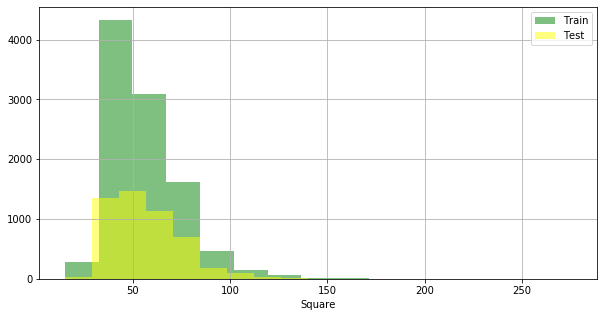

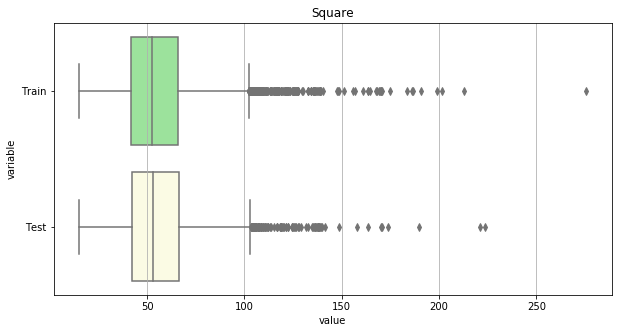

In [44]:
plot_hist('Square', train_data['Square'], test_data['Square'])
plot_boxplot('Square', train_data['Square'], test_data['Square'])

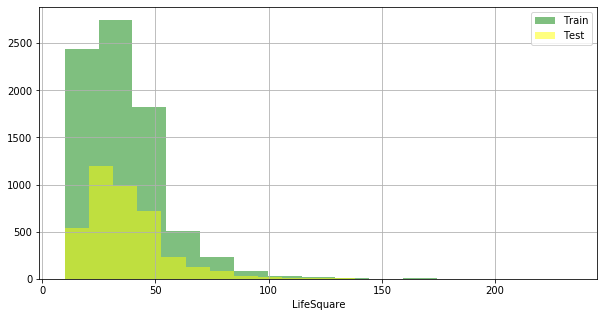

In [45]:
plot_hist('LifeSquare', train_data['LifeSquare'], test_data['LifeSquare'])

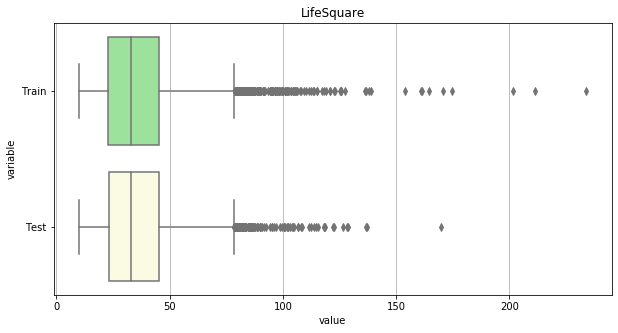

In [46]:
plot_boxplot('LifeSquare', train_data['LifeSquare'], test_data['LifeSquare'])

#### 1.1.4 KitchenSquare

Посмотрим на признак 'KitchenSquare':

In [47]:
train_data['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [48]:
test_data['KitchenSquare'].describe()

count    5000.000000
mean        5.976800
std         9.950018
min         0.000000
25%         1.000000
50%         6.000000
75%         9.000000
max       620.000000
Name: KitchenSquare, dtype: float64

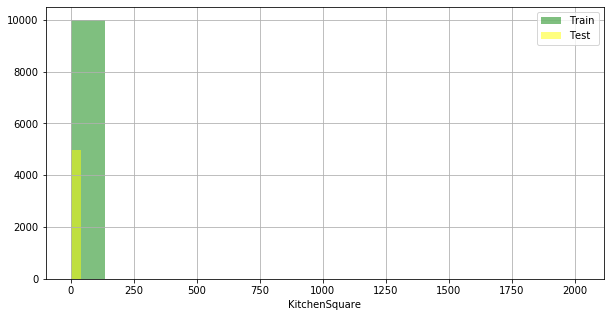

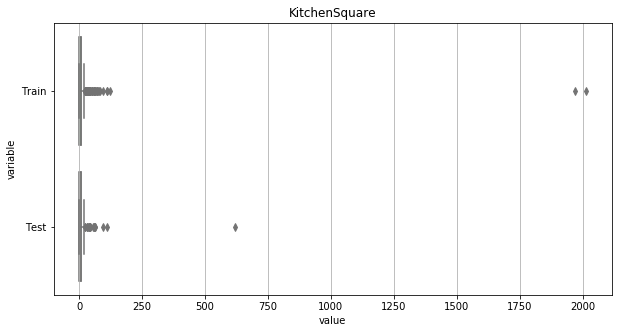

In [49]:
plot_hist('KitchenSquare', train_data['KitchenSquare'], test_data['KitchenSquare'])
plot_boxplot('KitchenSquare', train_data['KitchenSquare'], test_data['KitchenSquare'])

In [50]:
train_data.loc[train_data['KitchenSquare']>20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625285
551,1315,6,1.0,48.128114,45.023531,48.0,21,1.0,2013,0.243205,B,B,5,1564,0,540.0,0,0,B,146950.912410
622,12924,30,3.0,92.473796,53.649526,22.0,3,2.0,2018,0.000078,B,B,22,6398,141,1046.0,3,23,B,165521.195968
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
1077,9690,27,1.0,40.081042,37.834964,37.0,18,19.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,93218.650461
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014,0.017647,B,B,2,469,0,NaN,0,0,B,189244.249909
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.707579
1804,11459,79,1.0,98.727990,49.781722,22.0,18,24.0,2019,0.050756,B,B,24,5469,1,145.0,0,1,B,351021.797311
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,B,B,14,3369,24,4129.0,0,3,B,261125.669724
1867,3267,58,3.0,138.980817,138.004600,43.0,2,2.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,169528.896664


In [51]:
train_data.loc[train_data['KitchenSquare']>20,'KitchenSquare']=20#train_data['KitchenSquare'].mean()

In [52]:
test_data.loc[test_data['KitchenSquare']>20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
40,5428,27,2.0,62.326044,NaN,61.0,12,17.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
625,2249,62,1.0,78.281763,78.281763,34.0,5,24.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A
725,6977,167,3.0,125.693063,65.286558,24.0,7,34.0,2008,0.050272,B,B,21,4231,14,1020.0,0,3,B
803,3747,23,5.0,139.045763,89.790274,42.0,1,3.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B
870,13736,27,1.0,141.540215,91.704806,42.0,3,3.0,2013,0.014073,B,B,2,475,0,NaN,0,0,B
1447,1968,27,2.0,138.039182,92.484098,42.0,3,3.0,2016,0.014073,B,B,2,475,0,NaN,0,0,B
1456,5260,73,3.0,69.358242,51.247581,65.0,6,6.0,1931,0.042032,B,B,37,6856,84,1940.0,2,5,B
1777,3341,62,3.0,112.247841,112.247841,112.0,3,3.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
1964,14594,11,2.0,42.795304,24.223770,620.0,11,14.0,1972,0.038693,B,B,28,6533,1,1015.0,2,5,B
2140,4047,168,3.0,92.020293,42.533389,22.0,2,2.0,2018,0.341072,B,B,27,5664,48,2300.0,3,11,B


In [53]:
test_data.loc[test_data['KitchenSquare']>20,'KitchenSquare']=20#test_data['KitchenSquare'].mean()

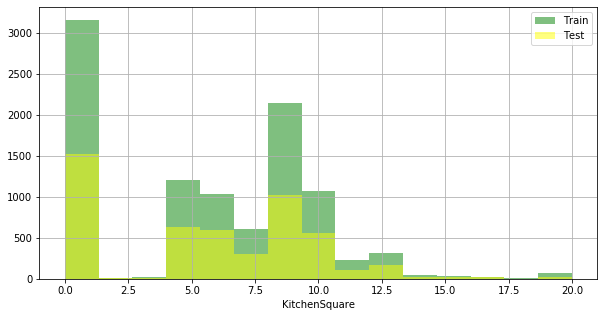

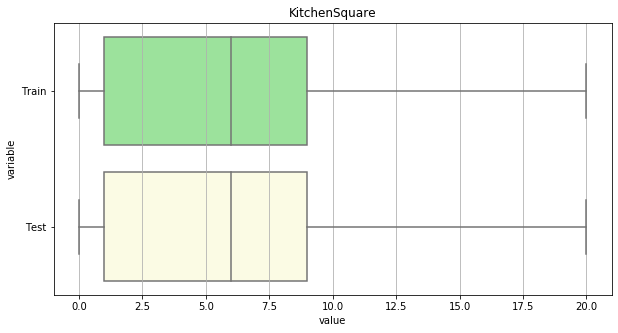

In [54]:
plot_hist('KitchenSquare', train_data['KitchenSquare'], test_data['KitchenSquare'])
plot_boxplot('KitchenSquare', train_data['KitchenSquare'], test_data['KitchenSquare'])

#### 1.1.5 Floor и HouseFloor

Посмотрим на признаки 'Floor' и 'HouseFloor':

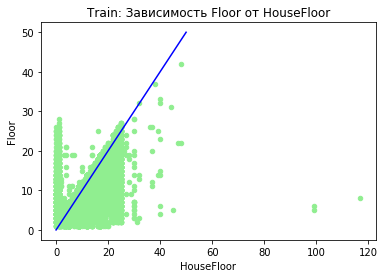

In [55]:
plot_scatter('Train: Зависимость Floor от HouseFloor', train_data, 'HouseFloor', 'Floor','LightGreen')
x = np.linspace(0, 50, 50)
plt.plot(x, x, color='b')

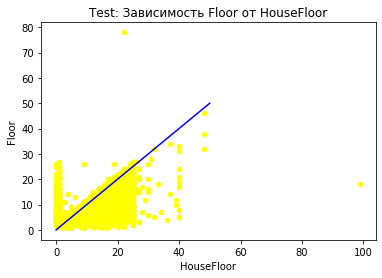

In [56]:
plot_scatter('Test: Зависимость Floor от HouseFloor', test_data, 'HouseFloor', 'Floor','Yellow')
x = np.linspace(0, 50, 50)
plt.plot(x, x, color='b')

In [57]:
test_data.loc[test_data['Floor']==78, 'Floor']=test_data.loc[test_data['Floor']==78, 'HouseFloor']

Видим, что есть строки, где этаж квартиры больше, чем этажность дома. Так как их много, заменим этажность дома номером этажа.

In [58]:
train_data.loc[train_data.Floor>train_data.HouseFloor,'HouseFloor']=train_data.loc[train_data.Floor>train_data.HouseFloor,'Floor']
test_data.loc[test_data.Floor>test_data.HouseFloor,'HouseFloor']=test_data.loc[test_data.Floor>test_data.HouseFloor,'Floor']

#### 1.1.6 HouseYear

Рассмотрим признак 'HouseYear'. Посмотрим на диаграмму распределения: сначала она не очень информативна, значит есть выбросы, которые надо обработать.

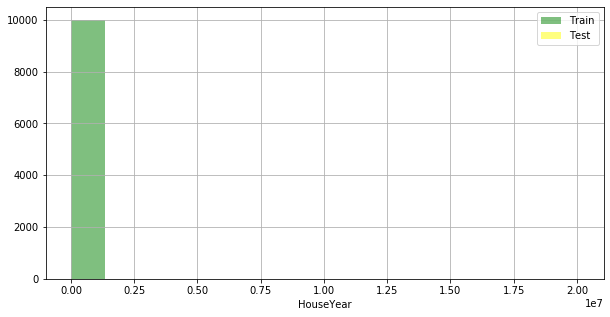

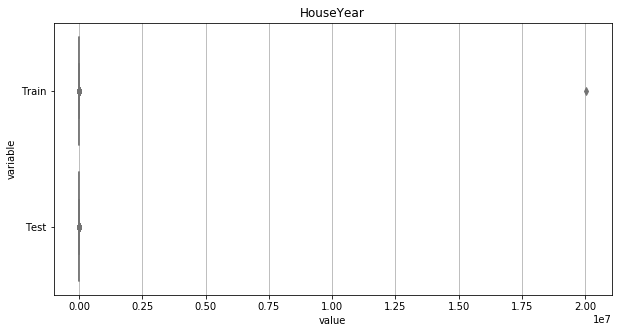

In [59]:
plot_hist('HouseYear', train_data['HouseYear'], test_data['HouseYear'])
plot_boxplot('HouseYear', train_data['HouseYear'], test_data['HouseYear'])

Сначала выведем строки, где указан слишком большой год постройки:

In [60]:
train_data.loc[train_data.HouseYear>2021]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


20052011 год заменим на 2011; 4968 год заменим на 1968 (считаем, что опечатка)

In [61]:
train_data.loc[train_data['HouseYear']==20052011,'HouseYear']=2011
train_data.loc[train_data['HouseYear']==4968,'HouseYear']=1968

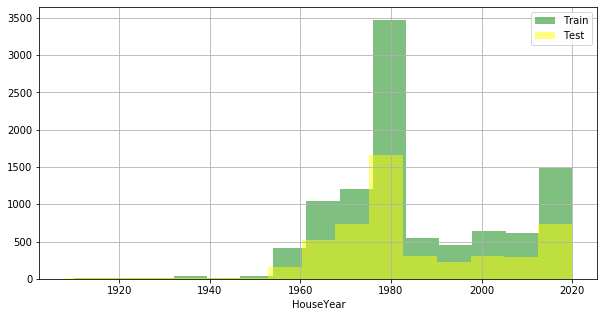

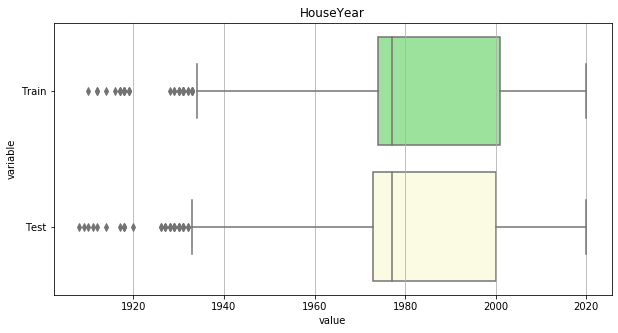

In [62]:
plot_hist('HouseYear', train_data['HouseYear'], test_data['HouseYear'])
plot_boxplot('HouseYear', train_data['HouseYear'], test_data['HouseYear'])

Такое распределение по признаку "HouseYear" нас устраивает.

#### 1.1.7 Ecology_1, Ecology_2 и Ecology_3

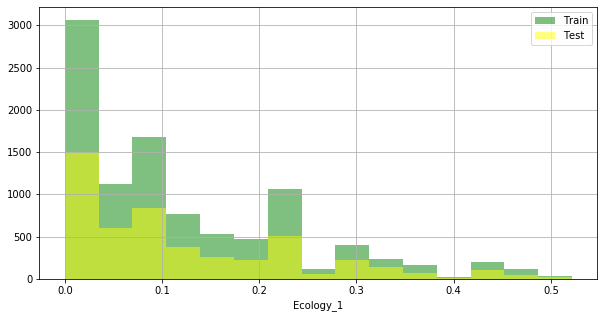

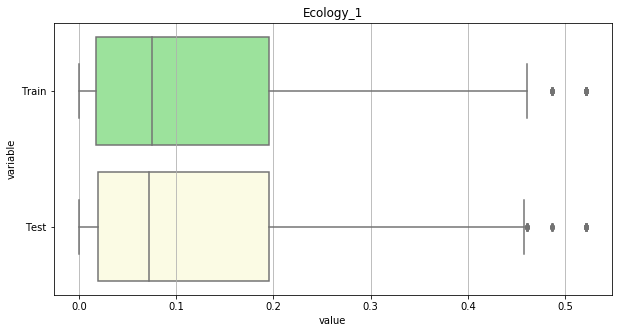

In [63]:
plot_hist('Ecology_1', train_data['Ecology_1'], test_data['Ecology_1'])
plot_boxplot('Ecology_1', train_data['Ecology_1'], test_data['Ecology_1'])

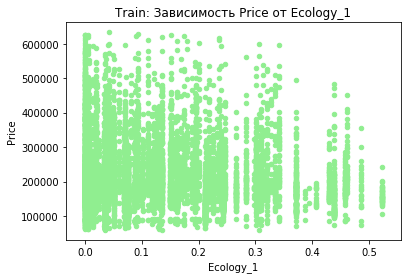

In [64]:
plot_scatter('Train: Зависимость Price от Ecology_1', train_data, 'Ecology_1', 'Price','LightGreen')

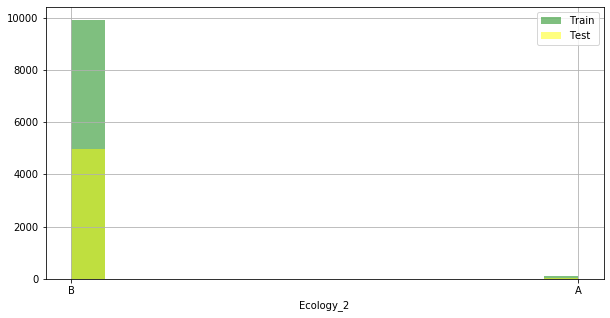

In [65]:
plot_hist('Ecology_2', train_data['Ecology_2'], test_data['Ecology_2'])

In [66]:
train_data['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [67]:
test_data['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

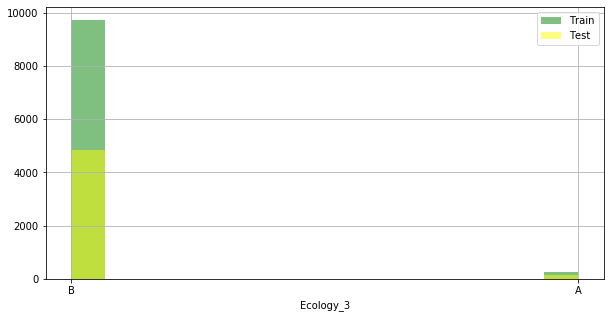

In [68]:
plot_hist('Ecology_3', train_data['Ecology_3'], test_data['Ecology_3'])

In [69]:
train_data['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [70]:
test_data['Ecology_3'].value_counts()

B    4851
A     149
Name: Ecology_3, dtype: int64

#### 1.1.8 Social_1, Social_2 и Social_3

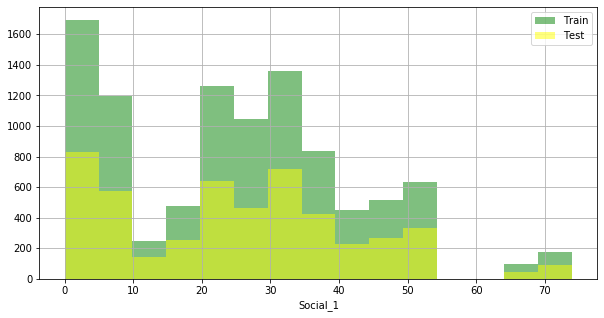

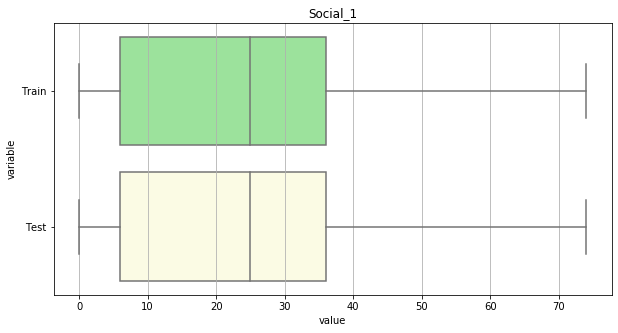

In [71]:
plot_hist('Social_1', train_data['Social_1'], test_data['Social_1'])
plot_boxplot('Social_1', train_data['Social_1'], test_data['Social_1'])

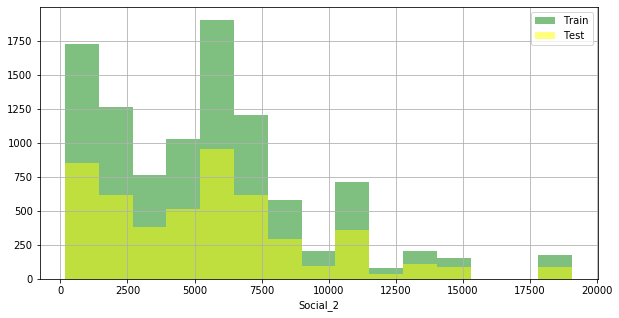

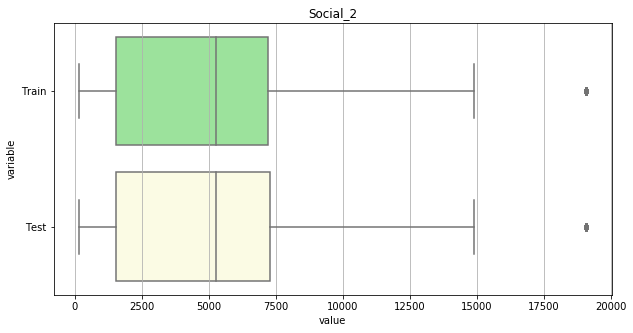

In [72]:
plot_hist('Social_2', train_data['Social_2'], test_data['Social_2'])
plot_boxplot('Social_2', train_data['Social_2'], test_data['Social_2'])

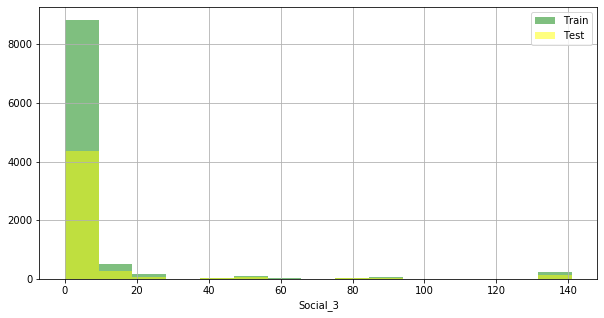

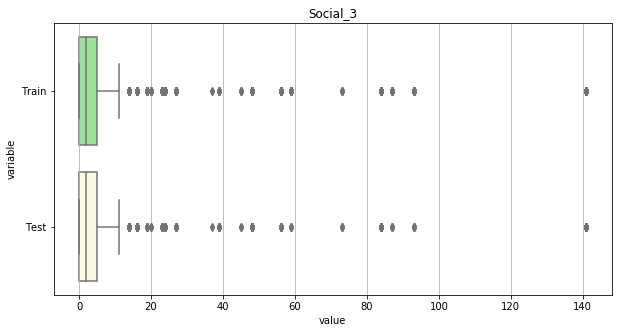

In [73]:
plot_hist('Social_3', train_data['Social_3'], test_data['Social_3'])
plot_boxplot('Social_3', train_data['Social_3'], test_data['Social_3'])

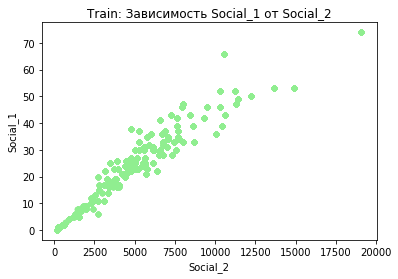

In [74]:
plot_scatter('Train: Зависимость Social_1 от Social_2', train_data, 'Social_2', 'Social_1','LightGreen')

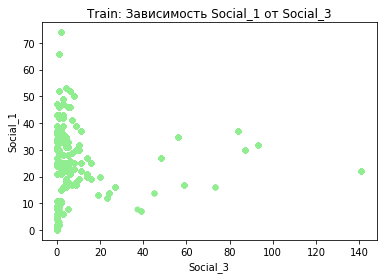

In [75]:
plot_scatter('Train: Зависимость Social_1 от Social_3', train_data, 'Social_3', 'Social_1','LightGreen')

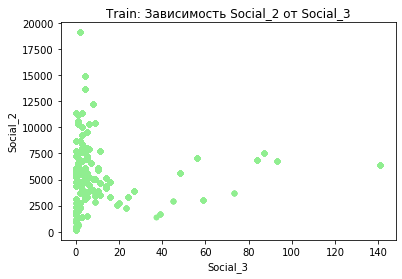

In [76]:
plot_scatter('Train: Зависимость Social_2 от Social_3', train_data, 'Social_3', 'Social_2','LightGreen')

In [77]:
train_features = train_data[['Social_1', 'Social_2', 'Social_3']]
train_features.corr()

,Social_1,Social_2,Social_3
Social_1,1.000000,0.955988,0.023721
Social_2,0.955988,1.000000,0.073379
Social_3,0.023721,0.073379,1.000000


In [78]:
test_features = test_data[['Social_1', 'Social_2', 'Social_3']]
test_features.corr()

,Social_1,Social_2,Social_3
Social_1,1.000000,0.955823,0.019577
Social_2,0.955823,1.000000,0.065041
Social_3,0.019577,0.065041,1.000000


Видим, что признаки Social_1 и Social_2 сильно коррелируют между собой. Поэтому удалим признак Social_2 как неинформативный.

In [79]:
train_data = train_data.drop(['Social_2'],axis=1)
test_data = test_data.drop(['Social_2'],axis=1)

#### 1.1.9 Healthcare_1	и Helthcare_2

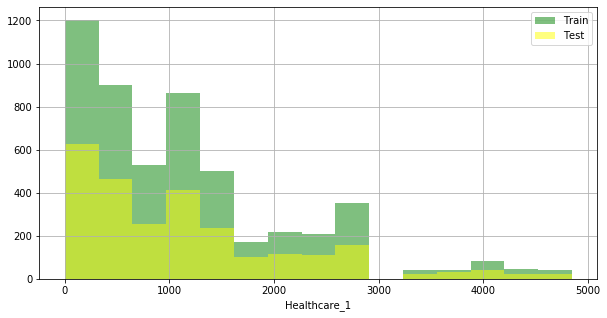

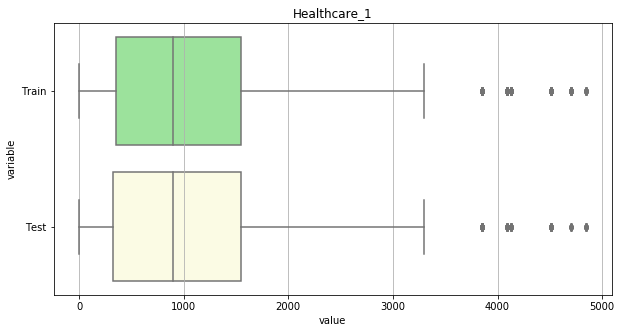

In [80]:
plot_hist('Healthcare_1', train_data['Healthcare_1'], test_data['Healthcare_1'])
plot_boxplot('Healthcare_1', train_data['Healthcare_1'], test_data['Healthcare_1'])

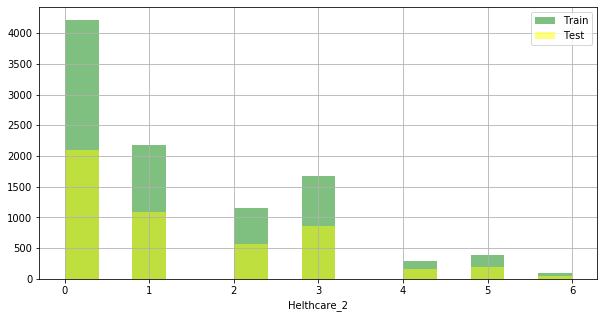

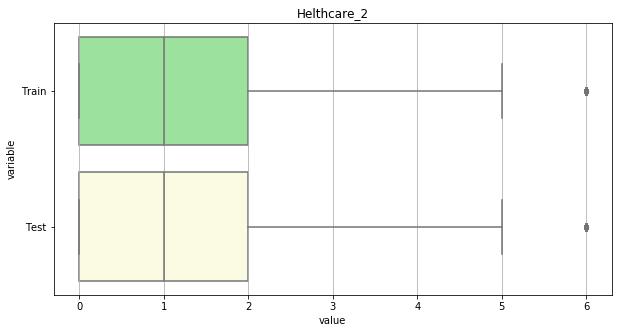

In [81]:
plot_hist('Helthcare_2', train_data['Helthcare_2'], test_data['Helthcare_2'])
plot_boxplot('Helthcare_2', train_data['Helthcare_2'], test_data['Helthcare_2'])

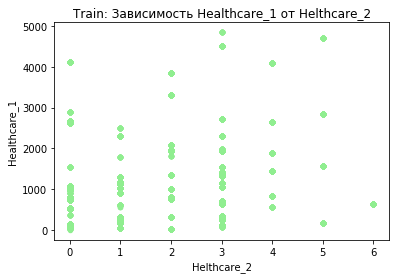

In [82]:
plot_scatter('Train: Зависимость Healthcare_1 от Helthcare_2', train_data, 'Helthcare_2', 'Healthcare_1','LightGreen')

#### 1.1.10  Shops_1 и Shops_2

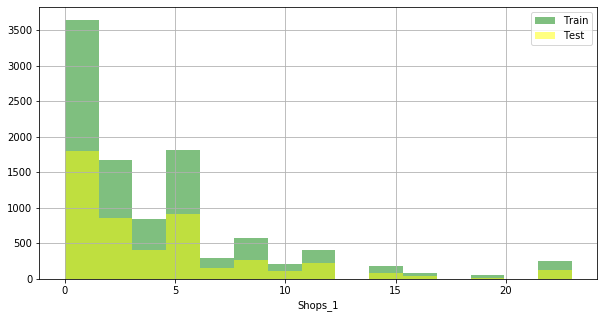

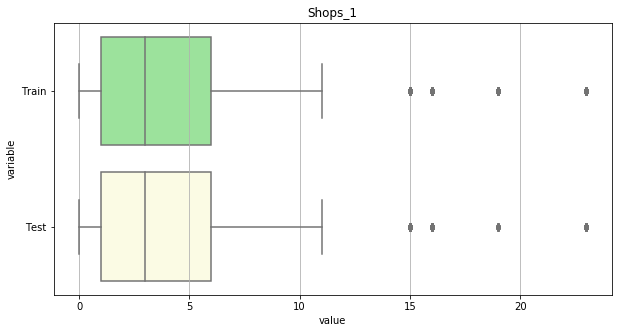

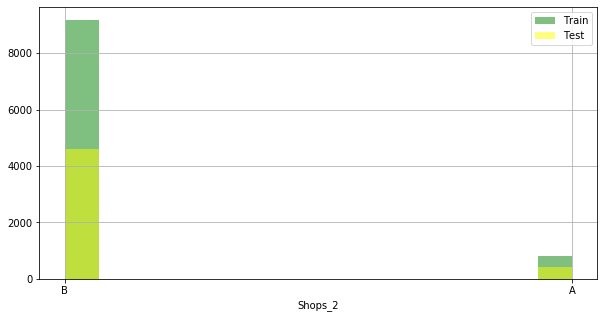

In [83]:
plot_hist('Shops_1', train_data['Shops_1'], test_data['Shops_1'])
plot_boxplot('Shops_1', train_data['Shops_1'], test_data['Shops_1'])
plot_hist('Shops_2', train_data['Shops_2'], test_data['Shops_2'])

#### 1.1.11 Новые признаки

**Добавим новый признак Price_per_meter**: средняя цена за квадратный метр в группировке по количеству комнат и районам.

In [84]:
train_data['Price_per_meter'] = train_data['Price'] / train_data['Square']
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_per_meter
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,5,NaN,0,11,B,184966.930730,3854.958571
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,1,240.0,1,16,B,300009.450063,4567.491245
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,0,229.0,1,3,B,220925.908524,4915.149522
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,3,1084.0,0,5,B,175616.227217,3291.591637
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,1,2078.0,2,4,B,150226.531644,3788.892642


In [85]:
stats1=train_data.groupby(['DistrictId','Rooms'],as_index=False)[['Price_per_meter']].mean()
train_data = train_data.drop('Price_per_meter',axis=1)
stats1.head()

,DistrictId,Rooms,Price_per_meter
0,0,1.0,3743.512621
1,0,2.0,3631.502943
2,0,3.0,3774.993359
3,1,1.0,3395.848843
4,1,2.0,3157.530011


In [86]:
train_data=join_stats1(train_data,stats1,train_data)
test_data=join_stats1(test_data,stats1,train_data,'test')

**Добавим новый признак Cluster_year**: попробуем сгруппировать наблюдения в кластеры по дате постройки дома в зависимости от района

In [87]:
com_feat = list(train_data.drop('Price',axis=1).columns)
com_data = pd.merge(train_data.drop('Price',axis=1), test_data, on=com_feat, how='outer')
com_data.shape

(15000, 19)

In [88]:
scaler=MinMaxScaler()
com_data_scaled=scaler.fit_transform(com_data.loc[:,['HouseYear','DistrictId']])

In [89]:
inertia_arr=[]
for i in range(2,30):
    temp_model=KMeans(n_clusters=i,random_state=47)
    temp_model.fit(com_data_scaled)
    temp_inertia=temp_model.inertia_
    print(temp_inertia)
    inertia_arr.append(temp_inertia)

566.3725480328094
321.18356503322076
244.43756364634817
187.2214671228165
157.6113247660304
133.21889412777386
118.95193441254463
106.44669145961629
96.4710875157291
87.17235934840167
78.25007577429393
71.35197021480018
65.34989800669463
60.352436518221694
55.667194158311034
52.29936920163486
48.9225620016465
47.19529385902946
44.31052337709011
42.34132689403362
39.90525397921313
38.359989297535286
36.198079377920976
35.094236304877604
33.49654958522949
32.337114378006426
31.1426480039594
29.53870336436014


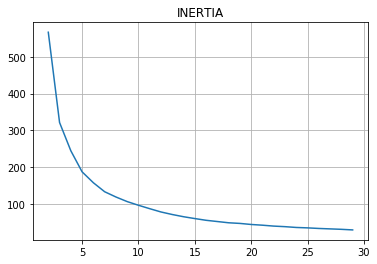

In [90]:
plt.plot([i for i in range(2,30)],inertia_arr)
plt.grid()
plt.title('INERTIA');

In [91]:
model=AgglomerativeClustering(n_clusters=7)

In [92]:
com_data['Cluster_year']=model.fit_predict(com_data_scaled)

Text(0.5, 1.0, 'Common Data')

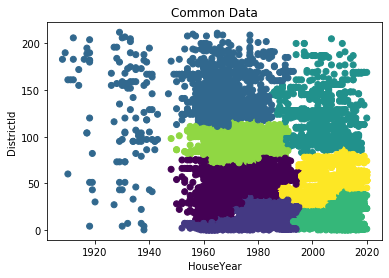

In [93]:
plt.scatter(com_data['HouseYear'],com_data['DistrictId'],c=com_data['Cluster_year'])
plt.xlabel('HouseYear')
plt.ylabel('DistrictId')
plt.title('Common Data')

In [94]:
train_data = pd.merge(train_data, com_data, on=com_feat, how='left')
test_data = pd.merge(test_data, com_data, on=com_feat, how='left')

train_data['Cluster_year']=train_data['Cluster_year'].astype(object)
test_data['Cluster_year']=test_data['Cluster_year'].astype(object)

print(train_data.shape, test_data.shape)

(10000, 21) (5000, 20)


**Добавим новый признак District_social**: попробуем сгруппировать наблюдения в кластеры по признаку Social_1 в зависимости от района

In [95]:
com_feat = list(train_data.drop('Price',axis=1).columns)
com_data = pd.merge(train_data.drop('Price',axis=1), test_data, on=com_feat, how='outer')
com_data.shape

(15000, 20)

In [96]:
scaler=MinMaxScaler()
com_data_scaled=scaler.fit_transform(com_data.loc[:,['Social_1','DistrictId']])

In [97]:
inertia_arr=[]
for i in range(2,30):
    temp_model=KMeans(n_clusters=i,random_state=47)
    temp_model.fit(com_data_scaled)
    temp_inertia=temp_model.inertia_
    print(temp_inertia)
    inertia_arr.append(temp_inertia)

810.7057981773166
490.11646506297757
328.32661241702806
266.53514303462947
229.40458810678487
198.2362998984828
170.43972516663524
148.10363768602423
121.43025633619816
110.82254226456226
100.33164223095064
89.14464355689586
80.70449118142854
72.97805088370272
64.9123077839365
60.16889590883189
56.239572075995504
52.78791293331796
48.44854885588782
46.28365813740019
43.65296534023976
40.57920870567267
38.29510819973293
37.61725795927195
35.3707771581482
34.46139013386027
32.47427177582229
31.299155828383103


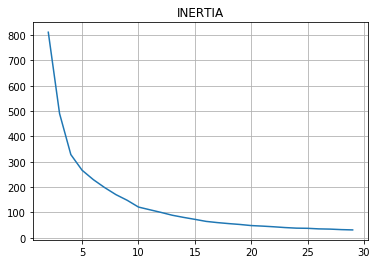

In [98]:
plt.plot([i for i in range(2,30)],inertia_arr)
plt.grid()
plt.title('INERTIA');

In [99]:
model=AgglomerativeClustering(n_clusters=5)

In [100]:
com_data['District_social']=model.fit_predict(com_data_scaled)

Text(0.5, 1.0, 'Common Data')

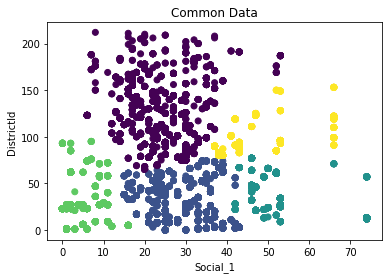

In [101]:
plt.scatter(com_data['Social_1'],com_data['DistrictId'],c=com_data['District_social'])
plt.xlabel('Social_1')
plt.ylabel('DistrictId')
plt.title('Common Data')

In [102]:
train_data = pd.merge(train_data, com_data, on=com_feat, how='left')
test_data = pd.merge(test_data, com_data, on=com_feat, how='left')

train_data['District_social']=train_data['District_social'].astype(object)
test_data['District_social']=test_data['District_social'].astype(object)

print(train_data.shape, test_data.shape)

(10000, 22) (5000, 21)


**Добавим новый признак District_shops**: попробуем сгруппировать наблюдения в кластеры по количеству магазинов в зависимости от района

In [103]:
com_feat = list(train_data.drop('Price',axis=1).columns)
com_data = pd.merge(train_data.drop('Price',axis=1), test_data, on=com_feat, how='outer')
com_data.shape

(15000, 21)

In [104]:
scaler=MinMaxScaler()
com_data_scaled=scaler.fit_transform(com_data.loc[:,['Shops_1','DistrictId']])

In [105]:
inertia_arr=[]
for i in range(2,30):
    temp_model=KMeans(n_clusters=i,random_state=47)
    temp_model.fit(com_data_scaled)
    temp_inertia=temp_model.inertia_
    print(temp_inertia)
    inertia_arr.append(temp_inertia)

763.5966973018482
428.74919314158717
326.0564274070398
253.35861262466966
215.8981594054072
182.47865003633686
151.4326682890513
132.09848017811868
115.37342164864987
103.27023369375273
89.56400061761269
80.01760350150059
71.93254780339629
64.9041947988523
59.00508249350085
54.481410535571754
49.132478126852426
45.980404203958514
40.98398314669533
40.92534979757807
37.72769321858371
35.79622744910609
32.68327437993746
31.55198990638754
29.4222715580001
27.915422698602672
27.198095111416393
24.837610748931134


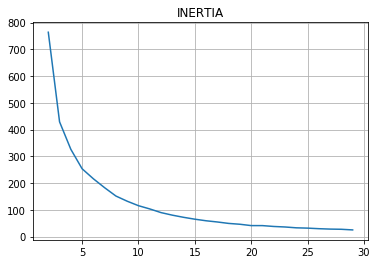

In [106]:
plt.plot([i for i in range(2,30)],inertia_arr)
plt.grid()
plt.title('INERTIA');

In [107]:
model=AgglomerativeClustering(n_clusters=8)

In [108]:
com_data['District_shops']=model.fit_predict(com_data_scaled)

Text(0.5, 1.0, 'Common Data')

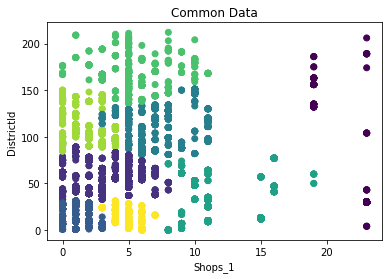

In [109]:
plt.scatter(com_data['Shops_1'],com_data['DistrictId'],c=com_data['District_shops'])
plt.xlabel('Shops_1')
plt.ylabel('DistrictId')
plt.title('Common Data')

In [110]:
train_data = pd.merge(train_data, com_data, on=com_feat, how='left')
test_data = pd.merge(test_data, com_data, on=com_feat, how='left')

train_data['District_shops']=train_data['District_shops'].astype(object)
test_data['District_shops']=test_data['District_shops'].astype(object)

print(train_data.shape, test_data.shape)

(10000, 23) (5000, 22)


**Добавим новый признак District_ecology**: попробуем сгруппировать наблюдения в кластеры по признаку Ecology_1 в зависимости от района

In [111]:
com_feat = list(train_data.drop('Price',axis=1).columns)
com_data = pd.merge(train_data.drop('Price',axis=1), test_data, on=com_feat, how='outer')
com_data.shape

(15000, 22)

In [112]:
scaler=MinMaxScaler()
com_data_scaled=scaler.fit_transform(com_data.loc[:,['Ecology_1','DistrictId']])

In [113]:
inertia_arr=[]
for i in range(2,30):
    temp_model=KMeans(n_clusters=i,random_state=47)
    temp_model.fit(com_data_scaled)
    temp_inertia=temp_model.inertia_
    print(temp_inertia)
    inertia_arr.append(temp_inertia)

841.3795844965045
498.8829107844828
364.2369583040052
293.2076922508471
229.21695686187684
201.70339383285904
176.5491344441659
157.81307705491636
136.17512833492543
121.2219182382417
108.50531634303874
98.97822934059728
88.5635952908283
80.84455637208738
75.37225842545584
66.67966995062007
60.19489932334367
55.92634467676904
55.29212620737778
50.7329008005872
48.71349322742412
44.38388267043673
41.07320833896895
39.81733665761957
36.9886950579284
34.99989284602535
33.639219493185486
31.974862036912985


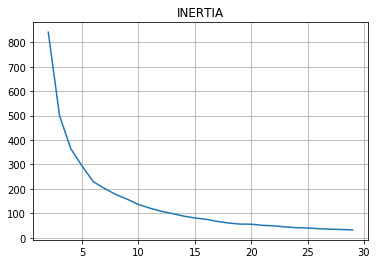

In [114]:
plt.plot([i for i in range(2,30)],inertia_arr)
plt.grid()
plt.title('INERTIA');

In [115]:
model=AgglomerativeClustering(n_clusters=6)

In [116]:
com_data['District_ecology']=model.fit_predict(com_data_scaled)

Text(0.5, 1.0, 'Common Data')

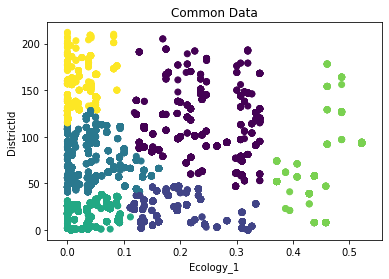

In [117]:
plt.scatter(com_data['Ecology_1'],com_data['DistrictId'],c=com_data['District_ecology'])
plt.xlabel('Ecology_1')
plt.ylabel('DistrictId')
plt.title('Common Data')

In [118]:
train_data = pd.merge(train_data, com_data, on=com_feat, how='left')
test_data = pd.merge(test_data, com_data, on=com_feat, how='left')

train_data['District_ecology']=train_data['District_ecology'].astype(object)
test_data['District_ecology']=test_data['District_ecology'].astype(object)

print(train_data.shape, test_data.shape)

(10000, 24) (5000, 23)


In [119]:
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_per_meter,Cluster_year,District_social,District_shops,District_ecology
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,NaN,0,11,B,184966.930730,4320.150470,0,1,4,3
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,B,300009.450063,4143.130929,0,2,4,2
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,229.0,1,3,B,220925.908524,4733.687024,0,1,1,2
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,B,175616.227217,2961.805147,0,1,1,4
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,B,150226.531644,4199.751497,5,0,6,2


In [120]:
test_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price_per_meter,Cluster_year,District_social,District_shops,District_ecology
0,725,58,2.0,49.882643,33.432782,6.0,6.0,14.0,1972,0.310199,...,1,NaN,0,0,B,2961.805147,0,3,1,0
1,15856,74,2.0,69.263183,NaN,1.0,6.0,6.0,1977,0.075779,...,3,NaN,0,2,B,3278.931977,5,3,1,2
2,5480,190,1.0,15.948246,15.948246,12.0,2.0,5.0,1909,0.000000,...,87,4702.0,5,5,B,3898.580636,2,0,5,5
3,15664,47,2.0,73.046609,51.940842,9.0,22.0,22.0,2007,0.101872,...,3,NaN,3,3,B,3841.195532,6,1,1,2
4,14275,27,1.0,47.527111,43.387569,1.0,17.0,17.0,2017,0.072158,...,1,NaN,0,0,A,2893.621067,4,3,2,3


In [121]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,16798.000000
Rooms,10000.0,1.886600,0.810436,1.000000,1.000000,2.000000,2.000000,5.000000
Square,10000.0,56.271398,19.121505,15.000000,41.865867,52.609490,65.983195,275.645284
LifeSquare,7885.0,36.208821,17.496250,10.000000,22.766534,32.767366,45.106707,233.949309
KitchenSquare,10000.0,5.742900,3.999100,0.000000,1.000000,6.000000,9.000000,20.000000
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,10000.0,13.435700,6.094012,1.000000,9.000000,14.000000,17.000000,117.000000
HouseYear,10000.0,1984.866300,18.412271,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,74.000000


In [122]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
Rooms,5000.0,1.907400,0.810282,1.000000,1.000000,2.000000,2.000000,6.000000
Square,5000.0,56.556350,19.052367,15.000000,41.989020,52.930550,66.392939,223.453689
LifeSquare,3959.0,36.277348,16.997579,10.000000,23.092026,32.925087,45.174091,169.901701
KitchenSquare,5000.0,5.747200,3.905988,0.000000,1.000000,6.000000,9.000000,20.000000
Floor,5000.0,8.620800,5.398040,1.000000,4.000000,7.000000,12.000000,46.000000
HouseFloor,5000.0,13.383800,6.165785,1.000000,9.000000,14.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867
Social_1,5000.0,24.933800,17.532202,0.000000,6.000000,25.000000,36.000000,74.000000


Посмотрим, как полученные признаки коррелируют между собой.

In [123]:
corr = train_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Price_per_meter
Id,1,-0.0079,-0.0058,-0.0054,0.014,0.0013,-0.0047,0.0035,0.018,-0.00077,-0.0094,-0.0039,0.0015,-0.0087,0.0099,0.012
Rooms,-0.0079,1,0.76,0.61,0.13,-0.0053,-0.036,-0.044,-0.03,0.077,0.015,0.046,0.064,0.054,0.57,-0.049
Square,-0.0058,0.76,1,0.79,0.1,0.12,0.14,0.19,-0.071,-0.081,0.022,-0.04,-0.034,0.01,0.58,-0.19
LifeSquare,-0.0054,0.61,0.79,1,-0.034,0.11,0.12,0.2,-0.065,-0.16,0.056,-0.042,-0.075,-0.0034,0.41,-0.23
KitchenSquare,0.014,0.13,0.1,-0.034,1,-0.017,0.069,0.18,0.026,0.37,-0.07,0.12,0.21,0.11,0.31,0.32
Floor,0.0013,-0.0053,0.12,0.11,-0.017,1,0.58,0.28,-0.016,-0.045,-0.0022,-0.14,-0.066,0.024,0.13,-0.066
HouseFloor,-0.0047,-0.036,0.14,0.12,0.069,0.58,1,0.45,-0.026,-0.07,-0.012,-0.18,-0.11,0.018,0.11,-0.12
HouseYear,0.0035,-0.044,0.19,0.2,0.18,0.28,0.45,1,-0.066,-0.048,-0.049,-0.21,-0.12,-0.0021,0.037,-0.22
Ecology_1,0.018,-0.03,-0.071,-0.065,0.026,-0.016,-0.026,-0.066,1,0.026,-0.12,-0.044,0.031,-0.077,-0.058,0.013
Social_1,-0.00077,0.077,-0.081,-0.16,0.37,-0.045,-0.07,-0.048,0.026,1,0.024,0.077,0.52,0.53,0.26,0.48


### 1.2 Обработка пропущенных значений

In [124]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 24 columns):
Id                  10000 non-null int64
DistrictId          10000 non-null object
Rooms               10000 non-null float64
Square              10000 non-null float64
LifeSquare          7885 non-null float64
KitchenSquare       10000 non-null float64
Floor               10000 non-null int64
HouseFloor          10000 non-null float64
HouseYear           10000 non-null int64
Ecology_1           10000 non-null float64
Ecology_2           10000 non-null object
Ecology_3           10000 non-null object
Social_1            10000 non-null int64
Social_3            10000 non-null int64
Healthcare_1        5202 non-null float64
Helthcare_2         10000 non-null int64
Shops_1             10000 non-null int64
Shops_2             10000 non-null object
Price               10000 non-null float64
Price_per_meter     10000 non-null float64
Cluster_year        10000 non-null object
District_s

In [125]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 23 columns):
Id                  5000 non-null int64
DistrictId          5000 non-null object
Rooms               5000 non-null float64
Square              5000 non-null float64
LifeSquare          3959 non-null float64
KitchenSquare       5000 non-null float64
Floor               5000 non-null float64
HouseFloor          5000 non-null float64
HouseYear           5000 non-null int64
Ecology_1           5000 non-null float64
Ecology_2           5000 non-null object
Ecology_3           5000 non-null object
Social_1            5000 non-null int64
Social_3            5000 non-null int64
Healthcare_1        2623 non-null float64
Helthcare_2         5000 non-null int64
Shops_1             5000 non-null int64
Shops_2             5000 non-null object
Price_per_meter     5000 non-null float64
Cluster_year        5000 non-null object
District_social     5000 non-null object
District_shops      5000 non-

Разделим признаки на вещественные и категориальные (признак "Id" пока добавим в категориальные, а потом уберем, т.к. он неинформативный):

In [126]:
cat_features = ['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2', 'Cluster_year', 'District_social', 'District_shops', 'District_ecology']
num_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price_per_meter', 'Price']

In [127]:
print(cat_features)
print(num_features)

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2', 'Cluster_year', 'District_social', 'District_shops', 'District_ecology']
['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price_per_meter', 'Price']


In [128]:
train_data_num = train_data[num_features]
train_data_cat = train_data[cat_features]

test_data_num = test_data[num_features[:-1]]
test_data_cat = test_data[cat_features]

# common_data_cat нужен для второго способа обработки категориальных признаков
common_data_cat = pd.merge(train_data_cat, test_data_cat, on=cat_features, how='outer')
common_data_cat.shape

(15000, 9)

Видим, что в тренировочных и тестовых данных есть пропущенные значения. Проработаем несколько вариантов обработки.

In [129]:
# Заведем переменную для хранения информации о переменных с обработанными данными
# Сделаем это для того, чтобы не вести за собой слишком длинные названия переменных
legend = []

**Гипотеза 1**: удалим признаки с пропущенными данными. Так как в обоих наборах данных пропущенные значения есть только в признаках "LifeSquare" и "Healthcare_1", то просто не будем рассматривать данные признаки при построении моделей.

In [130]:
legend.append('___hypothesis_1____')

train_dn = train_data_num.drop(['LifeSquare', 'Healthcare_1'],axis=1)
legend.append('train_dn = train_data_drop_nulls_features')

test_dn = test_data_num.drop(['LifeSquare', 'Healthcare_1'],axis=1)
legend.append('test_dn = test_data_drop_nulls_features')

In [131]:
print(train_dn.info(), test_dn.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 13 columns):
Rooms              10000 non-null float64
Square             10000 non-null float64
KitchenSquare      10000 non-null float64
Floor              10000 non-null int64
HouseFloor         10000 non-null float64
HouseYear          10000 non-null int64
Ecology_1          10000 non-null float64
Social_1           10000 non-null int64
Social_3           10000 non-null int64
Helthcare_2        10000 non-null int64
Shops_1            10000 non-null int64
Price_per_meter    10000 non-null float64
Price              10000 non-null float64
dtypes: float64(7), int64(6)
memory usage: 1.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 12 columns):
Rooms              5000 non-null float64
Square             5000 non-null float64
KitchenSquare      5000 non-null float64
Floor              5000 non-null float64
HouseFloor         5000 non-null floa

In [132]:
legend

['___hypothesis_1____',
 'train_dn = train_data_drop_nulls_features',
 'test_dn = test_data_drop_nulls_features']

**Гипотеза 2**: заменим пропущенные значения на 0. Тогда данный признак не будет вносить вклад в обучение модели для данного конкретного наблюдения.

In [133]:
legend.append('___hypothesis_2____')

train_zn = train_data_num.copy()
legend.append('train_zn = train_data_zero_fill_nulls')
train_zn['LifeSquare']=train_zn['LifeSquare'].fillna(0)
train_zn['Healthcare_1']=train_zn['Healthcare_1'].fillna(0)

test_zn = test_data_num.copy()
legend.append('test_zn = test_data_zero_fill_nulls')
test_zn['LifeSquare']=test_zn['LifeSquare'].fillna(0)
test_zn['Healthcare_1']=test_zn['Healthcare_1'].fillna(0)

In [134]:
print(train_zn.info(), test_zn.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 15 columns):
Rooms              10000 non-null float64
Square             10000 non-null float64
LifeSquare         10000 non-null float64
KitchenSquare      10000 non-null float64
Floor              10000 non-null int64
HouseFloor         10000 non-null float64
HouseYear          10000 non-null int64
Ecology_1          10000 non-null float64
Social_1           10000 non-null int64
Social_3           10000 non-null int64
Healthcare_1       10000 non-null float64
Helthcare_2        10000 non-null int64
Shops_1            10000 non-null int64
Price_per_meter    10000 non-null float64
Price              10000 non-null float64
dtypes: float64(9), int64(6)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 14 columns):
Rooms              5000 non-null float64
Square             5000 non-null float64
LifeSquare         5000 non-null fl

In [135]:
legend

['___hypothesis_1____',
 'train_dn = train_data_drop_nulls_features',
 'test_dn = test_data_drop_nulls_features',
 '___hypothesis_2____',
 'train_zn = train_data_zero_fill_nulls',
 'test_zn = test_data_zero_fill_nulls']

**Гипотеза 3**: заменим пропущенные значения на средние. Тогда данный признак будет давать такой же вклад, как и среднее значение признака по всем наблюдениям.

In [136]:
legend.append('___hypothesis_3____')

train_mn = train_data_num.copy()
legend.append('train_mn = train_data_mean_fill_nulls')
train_mn['LifeSquare']=train_mn['LifeSquare'].fillna(train_mn['LifeSquare'].mean())
train_mn['Healthcare_1']=train_mn['Healthcare_1'].fillna(train_mn['Healthcare_1'].mean())

test_mn = test_data_num.copy()
legend.append('test_mn = test_data_mean_fill_nulls')
test_mn['LifeSquare']=test_mn['LifeSquare'].fillna(test_mn['LifeSquare'].mean())
test_mn['Healthcare_1']=test_mn['Healthcare_1'].fillna(test_mn['Healthcare_1'].mean())

In [137]:
print(train_mn.info(), test_mn.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 15 columns):
Rooms              10000 non-null float64
Square             10000 non-null float64
LifeSquare         10000 non-null float64
KitchenSquare      10000 non-null float64
Floor              10000 non-null int64
HouseFloor         10000 non-null float64
HouseYear          10000 non-null int64
Ecology_1          10000 non-null float64
Social_1           10000 non-null int64
Social_3           10000 non-null int64
Healthcare_1       10000 non-null float64
Helthcare_2        10000 non-null int64
Shops_1            10000 non-null int64
Price_per_meter    10000 non-null float64
Price              10000 non-null float64
dtypes: float64(9), int64(6)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 14 columns):
Rooms              5000 non-null float64
Square             5000 non-null float64
LifeSquare         5000 non-null fl

In [138]:
legend

['___hypothesis_1____',
 'train_dn = train_data_drop_nulls_features',
 'test_dn = test_data_drop_nulls_features',
 '___hypothesis_2____',
 'train_zn = train_data_zero_fill_nulls',
 'test_zn = test_data_zero_fill_nulls',
 '___hypothesis_3____',
 'train_mn = train_data_mean_fill_nulls',
 'test_mn = test_data_mean_fill_nulls']

**Гипотеза 4**: вычислим средний коэффициент отношения признака "Square" к признаку "LifeSquare", и запишем в пропущенные значения признака "LifeSquare" признак "Square", деленый на этот коэффициент. Признак "Healthcare_1" удалим, так как в нем пропущена примерно половина значений от всех наблюдений, то есть считаем его неинформативным.

In [139]:
legend.append('___hypothesis_4____')

train_coef = (train_data_num.Square/train_data_num.LifeSquare).mean()
train_fn = train_data_num.copy()
train_fn['LifeSquare']=train_fn['LifeSquare'].fillna(train_fn['Square']/train_coef)
train_fn = train_fn.drop('Healthcare_1',axis=1)
legend.append('train_fn = train_data_fill_nulls_features_with_coefficient')

test_coef = (test_data_num.Square/test_data_num.LifeSquare).mean()
test_fn = test_data_num.copy()
test_fn['LifeSquare']=test_fn['LifeSquare'].fillna(test_fn['Square']/test_coef)
test_fn = test_fn.drop('Healthcare_1',axis=1)
legend.append('test_fn = test_data_fill_nulls_features_with_coefficient')

In [140]:
print(train_fn.info(), test_fn.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 14 columns):
Rooms              10000 non-null float64
Square             10000 non-null float64
LifeSquare         10000 non-null float64
KitchenSquare      10000 non-null float64
Floor              10000 non-null int64
HouseFloor         10000 non-null float64
HouseYear          10000 non-null int64
Ecology_1          10000 non-null float64
Social_1           10000 non-null int64
Social_3           10000 non-null int64
Helthcare_2        10000 non-null int64
Shops_1            10000 non-null int64
Price_per_meter    10000 non-null float64
Price              10000 non-null float64
dtypes: float64(8), int64(6)
memory usage: 1.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 13 columns):
Rooms              5000 non-null float64
Square             5000 non-null float64
LifeSquare         5000 non-null float64
KitchenSquare      5000 non-null flo

In [141]:
legend

['___hypothesis_1____',
 'train_dn = train_data_drop_nulls_features',
 'test_dn = test_data_drop_nulls_features',
 '___hypothesis_2____',
 'train_zn = train_data_zero_fill_nulls',
 'test_zn = test_data_zero_fill_nulls',
 '___hypothesis_3____',
 'train_mn = train_data_mean_fill_nulls',
 'test_mn = test_data_mean_fill_nulls',
 '___hypothesis_4____',
 'train_fn = train_data_fill_nulls_features_with_coefficient',
 'test_fn = test_data_fill_nulls_features_with_coefficient']

**Гипотеза 5**: вычислим средний коэффициент отношения признака "Square" к признаку "LifeSquare", и запишем в пропущенные значения признака "LifeSquare" признак "Square", деленый на этот коэффициент. Пустые значения признака "Healthcare_1" заполним нулями.

In [142]:
legend.append('___hypothesis_5____')

train_coef = (train_data_num.Square/train_data_num.LifeSquare).mean()
train_fzn = train_data_num.copy()
train_fzn['LifeSquare']=train_fzn['LifeSquare'].fillna(train_fzn['Square']/train_coef)
train_fzn['Healthcare_1']=train_fzn['Healthcare_1'].fillna(0)
legend.append('train_fzn = train_data_fill_nulls_features_with_coefficient_and_zero_healthcare')

test_coef = (test_data_num.Square/test_data_num.LifeSquare).mean()
test_fzn = test_data_num.copy()
test_fzn['LifeSquare']=test_fzn['LifeSquare'].fillna(test_fzn['Square']/test_coef)
test_fzn['Healthcare_1']=test_fzn['Healthcare_1'].fillna(0)
legend.append('test_fzn = test_data_fill_nulls_features_with_coefficient_and_zero_healthcare')

In [143]:
print(train_fzn.info(), test_fzn.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 15 columns):
Rooms              10000 non-null float64
Square             10000 non-null float64
LifeSquare         10000 non-null float64
KitchenSquare      10000 non-null float64
Floor              10000 non-null int64
HouseFloor         10000 non-null float64
HouseYear          10000 non-null int64
Ecology_1          10000 non-null float64
Social_1           10000 non-null int64
Social_3           10000 non-null int64
Healthcare_1       10000 non-null float64
Helthcare_2        10000 non-null int64
Shops_1            10000 non-null int64
Price_per_meter    10000 non-null float64
Price              10000 non-null float64
dtypes: float64(9), int64(6)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 14 columns):
Rooms              5000 non-null float64
Square             5000 non-null float64
LifeSquare         5000 non-null fl

In [144]:
legend

['___hypothesis_1____',
 'train_dn = train_data_drop_nulls_features',
 'test_dn = test_data_drop_nulls_features',
 '___hypothesis_2____',
 'train_zn = train_data_zero_fill_nulls',
 'test_zn = test_data_zero_fill_nulls',
 '___hypothesis_3____',
 'train_mn = train_data_mean_fill_nulls',
 'test_mn = test_data_mean_fill_nulls',
 '___hypothesis_4____',
 'train_fn = train_data_fill_nulls_features_with_coefficient',
 'test_fn = test_data_fill_nulls_features_with_coefficient',
 '___hypothesis_5____',
 'train_fzn = train_data_fill_nulls_features_with_coefficient_and_zero_healthcare',
 'test_fzn = test_data_fill_nulls_features_with_coefficient_and_zero_healthcare']

### 1.3 Обработка категориальных признаков

#### 1.3.0 Id

In [145]:
test_ids = test_data_cat['Id'].astype('int64')

#### 1.3.1 Dummy-переменные

Всем категориальным признакам поставим в соответствие наборы из 0 и 1, используя для этого dummy-переменные:

In [146]:
legend.append('___hypothesis_6____')
train_cat_d=pd.get_dummies(train_data_cat.drop(['Id'],axis=1))
legend.append('train_cat_d = train_data_cat_code_with_dummy')
test_cat_d=pd.get_dummies(test_data_cat.drop(['Id'],axis=1))
legend.append('test_cat_d = test_data_cat_code_with_dummy')

In [147]:
print(train_cat_d.shape, test_cat_d.shape)

(10000, 237) (5000, 233)


Видим, что получили разное количество признаков в обучающей и тестовой выборке. Это говорит о наличии разных значений категорий.

In [148]:
diff_train_test = list(set(train_cat_d.columns) - set(test_cat_d.columns))
diff_train_test

['DistrictId_158',
 'DistrictId_133',
 'DistrictId_207',
 'DistrictId_174',
 'DistrictId_162',
 'DistrictId_117',
 'DistrictId_202',
 'DistrictId_195',
 'DistrictId_50',
 'DistrictId_201',
 'DistrictId_199']

In [149]:
diff_test_train = list(set(test_cat_d.columns) - set(train_cat_d.columns))
diff_test_train

['DistrictId_198',
 'DistrictId_210',
 'DistrictId_206',
 'DistrictId_204',
 'DistrictId_203',
 'DistrictId_211',
 'DistrictId_212']

Заполним данные признаки нулями:

In [150]:
train_zero_list = [0] * train_cat_d.shape[0]
for cat in diff_test_train:
    train_cat_d[cat] = train_zero_list
    
test_zero_list = [0] * test_cat_d.shape[0]
for cat in diff_train_test:
    test_cat_d[cat] = test_zero_list
    
print(train_cat_d.shape, test_cat_d.shape)

(10000, 244) (5000, 244)


#### 1.3.2 "Smart way" 

Заменим каждую категорию числом входящих в неё наблюдений. Количество наблюдений будем считать по общей выборке, чтобы минимизировать риск переобучения.

In [151]:
legend.append('___hypothesis_7____')
data_cat_s = smart_cat_encode(common_data_cat)

train_cat_s = pd.merge(train_data_cat['Id'],data_cat_s, on=['Id'], how='left')
train_cat_s = train_cat_s.drop(['Id'],axis=1)
legend.append('train_cat_s = train_data_cat_code_with_smart')

test_cat_s = pd.merge(test_data_cat['Id'],data_cat_s, on=['Id'], how='left')
test_cat_s = test_cat_s.drop(['Id'],axis=1)
legend.append('test_cat_s = test_data_cat_code_with_smart')

In [152]:
print(train_cat_s.shape, test_cat_s.shape)

(10000, 8) (5000, 8)


In [153]:
train_cat_s.head()

,DistrictId_size,Ecology_2_size,Ecology_3_size,Shops_2_size,Cluster_year_size,District_social_size,District_shops_size,District_ecology_size
0,36,14855,14576,13763,3093,4939,1490,4945
1,131,14855,14576,13763,3093,1759,1490,3468
2,265,14855,14576,13763,3093,4939,3593,3468
3,270,14855,14576,13763,3093,4939,3593,800
4,139,14855,14576,13763,1811,2725,1231,3468


### 1.4 Масштабирование признаков

In [154]:
legend

['___hypothesis_1____',
 'train_dn = train_data_drop_nulls_features',
 'test_dn = test_data_drop_nulls_features',
 '___hypothesis_2____',
 'train_zn = train_data_zero_fill_nulls',
 'test_zn = test_data_zero_fill_nulls',
 '___hypothesis_3____',
 'train_mn = train_data_mean_fill_nulls',
 'test_mn = test_data_mean_fill_nulls',
 '___hypothesis_4____',
 'train_fn = train_data_fill_nulls_features_with_coefficient',
 'test_fn = test_data_fill_nulls_features_with_coefficient',
 '___hypothesis_5____',
 'train_fzn = train_data_fill_nulls_features_with_coefficient_and_zero_healthcare',
 'test_fzn = test_data_fill_nulls_features_with_coefficient_and_zero_healthcare',
 '___hypothesis_6____',
 'train_cat_d = train_data_cat_code_with_dummy',
 'test_cat_d = test_data_cat_code_with_dummy',
 '___hypothesis_7____',
 'train_cat_s = train_data_cat_code_with_smart',
 'test_cat_s = test_data_cat_code_with_smart']

In [155]:
target_dn=train_dn['Price']
train_dn=train_dn.drop(['Price'],axis=1)

target_zn=train_zn['Price']
train_zn=train_zn.drop(['Price'],axis=1)

target_mn=train_mn['Price']
train_mn=train_mn.drop(['Price'],axis=1)

target_fn=train_fn['Price']
train_fn=train_fn.drop(['Price'],axis=1)

target_fzn=train_fzn['Price']
train_fzn=train_fzn.drop(['Price'],axis=1)

In [156]:
scaler_dn = StandardScaler()
scaler_dn.fit(train_dn)
train_dn_scaled = scaler_dn.transform(train_dn)
test_dn_scaled = scaler_dn.transform(test_dn)

scaler_zn = StandardScaler()
scaler_zn.fit(train_zn)
train_zn_scaled = scaler_zn.transform(train_zn)
test_zn_scaled = scaler_zn.transform(test_zn)

scaler_mn = StandardScaler()
scaler_mn.fit(train_mn)
train_mn_scaled = scaler_mn.transform(train_mn)
test_mn_scaled = scaler_mn.transform(test_mn)

scaler_fn = StandardScaler()
scaler_fn.fit(train_fn)
train_fn_scaled = scaler_fn.transform(train_fn)
test_fn_scaled = scaler_fn.transform(test_fn)

scaler_fzn = StandardScaler()
scaler_fzn.fit(train_fzn)
train_fzn_scaled = scaler_fzn.transform(train_fzn)
test_fzn_scaled = scaler_fzn.transform(test_fzn)

scaler_cat_s = StandardScaler()
scaler_cat_s.fit(train_cat_s)
train_cat_s_scaled = scaler_cat_s.transform(train_cat_s)
test_cat_s_scaled = scaler_cat_s.transform(test_cat_s)

### 1.5 Объединение обработанных данных

Разобьем тренировочные данные на обучающие и валидационные выборки:

In [157]:
(X_train_dn_num, 
 X_valid_dn_num, 
 y_train_dn, y_valid_dn) = train_test_split(train_dn_scaled, target_dn, test_size=0.3, random_state=47)

(X_train_zn_num, 
 X_valid_zn_num, 
 y_train_zn, y_valid_zn) = train_test_split(train_zn_scaled, target_zn, test_size=0.3, random_state=47)

(X_train_mn_num, 
 X_valid_mn_num, 
 y_train_mn, y_valid_mn) = train_test_split(train_mn_scaled, target_mn, test_size=0.3, random_state=47)

(X_train_fn_num, 
 X_valid_fn_num, 
 y_train_fn, y_valid_fn) = train_test_split(train_fn_scaled, target_fn, test_size=0.3, random_state=47)

(X_train_fzn_num, 
 X_valid_fzn_num, 
 y_train_fzn, y_valid_fzn) = train_test_split(train_fzn_scaled, target_fzn, test_size=0.3, random_state=47)

(X_train_cat_d,
 X_valid_cat_d) = train_test_split(train_cat_d, 
                                   test_size=0.3, 
                                   random_state=47)

(X_train_cat_s,
 X_valid_cat_s) = train_test_split(train_cat_s_scaled, 
                                   test_size=0.3, 
                                   random_state=47)

Теперь соединим числовые и категориальные признаки:

In [158]:
# dummy
X_train_dn_d = np.hstack((X_train_dn_num, X_train_cat_d))
X_valid_dn_d = np.hstack((X_valid_dn_num, X_valid_cat_d))

X_train_zn_d = np.hstack((X_train_zn_num, X_train_cat_d))
X_valid_zn_d = np.hstack((X_valid_zn_num, X_valid_cat_d))

X_train_mn_d = np.hstack((X_train_mn_num, X_train_cat_d))
X_valid_mn_d = np.hstack((X_valid_mn_num, X_valid_cat_d))

X_train_fn_d = np.hstack((X_train_fn_num, X_train_cat_d))
X_valid_fn_d = np.hstack((X_valid_fn_num, X_valid_cat_d))

X_train_fzn_d = np.hstack((X_train_fzn_num, X_train_cat_d))
X_valid_fzn_d = np.hstack((X_valid_fzn_num, X_valid_cat_d))

# smart
X_train_dn_s = np.hstack((X_train_dn_num, X_train_cat_s))
X_valid_dn_s = np.hstack((X_valid_dn_num, X_valid_cat_s))

X_train_zn_s = np.hstack((X_train_zn_num, X_train_cat_s))
X_valid_zn_s = np.hstack((X_valid_zn_num, X_valid_cat_s))

X_train_mn_s = np.hstack((X_train_mn_num, X_train_cat_s))
X_valid_mn_s = np.hstack((X_valid_mn_num, X_valid_cat_s))

X_train_fn_s = np.hstack((X_train_fn_num, X_train_cat_s))
X_valid_fn_s = np.hstack((X_valid_fn_num, X_valid_cat_s))

X_train_fzn_s = np.hstack((X_train_fzn_num, X_train_cat_s))
X_valid_fzn_s = np.hstack((X_valid_fzn_num, X_valid_cat_s))

Тестовые данные просто соединим без разбиения:

In [159]:
test_dn_full_d = np.hstack((test_dn_scaled, test_cat_d))
test_zn_full_d = np.hstack((test_zn_scaled, test_cat_d))
test_mn_full_d = np.hstack((test_mn_scaled, test_cat_d))
test_fn_full_d = np.hstack((test_fn_scaled, test_cat_d))
test_fzn_full_d = np.hstack((test_fzn_scaled, test_cat_d))

test_dn_full_s = np.hstack((test_dn_scaled, test_cat_s_scaled))
test_zn_full_s = np.hstack((test_zn_scaled, test_cat_s_scaled))
test_mn_full_s = np.hstack((test_mn_scaled, test_cat_s_scaled))
test_fn_full_s = np.hstack((test_fn_scaled, test_cat_s_scaled))
test_fzn_full_s = np.hstack((test_fzn_scaled, test_cat_s_scaled))

In [160]:
features_names_dn_d = list(train_dn.columns)+list(train_cat_d.columns)
features_names_dn_s = list(train_dn.columns)+list(train_cat_s.columns)

features_names_zn_d = list(train_zn.columns)+list(train_cat_d.columns)
features_names_zn_s = list(train_zn.columns)+list(train_cat_s.columns)

features_names_mn_d = list(train_mn.columns)+list(train_cat_d.columns)
features_names_mn_s = list(train_mn.columns)+list(train_cat_s.columns)

features_names_fn_d = list(train_fn.columns)+list(train_cat_d.columns)
features_names_fn_s = list(train_fn.columns)+list(train_cat_s.columns)

features_names_fzn_d = list(train_fzn.columns)+list(train_cat_d.columns)
features_names_fzn_s = list(train_fzn.columns)+list(train_cat_s.columns)

In [161]:
print(X_train_dn_d.shape, test_dn_full_d.shape)
print(X_train_zn_d.shape, test_zn_full_d.shape)
print(X_train_mn_d.shape, test_mn_full_d.shape)
print(X_train_fn_d.shape, test_fn_full_d.shape)
print(X_train_fzn_d.shape, test_fzn_full_d.shape)
print()
print(X_train_dn_s.shape, test_dn_full_s.shape)
print(X_train_zn_s.shape, test_zn_full_s.shape)
print(X_train_mn_s.shape, test_mn_full_s.shape)
print(X_train_fn_s.shape, test_fn_full_s.shape)
print(X_train_fzn_s.shape, test_fzn_full_s.shape)

(7000, 256) (5000, 256)
(7000, 258) (5000, 258)
(7000, 258) (5000, 258)
(7000, 257) (5000, 257)
(7000, 258) (5000, 258)

(7000, 20) (5000, 20)
(7000, 22) (5000, 22)
(7000, 22) (5000, 22)
(7000, 21) (5000, 21)
(7000, 22) (5000, 22)


## Шаг 2: Выбор модели

### 2.1 Выбор тренировочного датасета

Проверим получившиеся датасеты на двух моделях: LinearRegression и RandomForestRegressor. Параметры моделей возьмем по умолчанию.

In [162]:
datasets_results = pd.DataFrame()
dataset_name = []
model_name = []
r2_result = []
mse_result = []

def compare_datasets(model, name_model, xtrain, ytrain, xvalid, yvalid, dataset_name, name_dataset, model_name, r2_result, mse_result):
    mod=model
    mod.fit(xtrain, ytrain)
    ypred=mod.predict(xvalid)
    dataset_name.append(name_dataset)
    model_name.append(name_model)
    r2_result.append(r2(yvalid,ypred))
    mse_result.append(MSE(yvalid,ypred))
    print(name_model, name_dataset, r2(yvalid,ypred), MSE(yvalid,ypred))

In [163]:
X_train_list = [X_train_dn_d, X_train_dn_s, X_train_zn_d, X_train_zn_s, X_train_mn_d, X_train_mn_s, X_train_fn_d, X_train_fn_s, X_train_fzn_d, X_train_fzn_s]
X_valid_list = [X_valid_dn_d, X_valid_dn_s, X_valid_zn_d, X_valid_zn_s, X_valid_mn_d, X_valid_mn_s, X_valid_fn_d, X_valid_fn_s, X_valid_fzn_d, X_valid_fzn_s]
y_train_list = [y_train_dn, y_train_zn, y_train_mn, y_train_fn, y_train_fzn]
y_valid_list = [y_valid_dn, y_valid_zn, y_valid_mn, y_valid_fn, y_valid_fzn]
names = ['dn_d', 'dn_s', 'zn_d', 'zn_s', 'mn_d', 'mn_s', 'fn_d', 'fn_s', 'fzn_d', 'fzn_s']

for i in range(len(X_train_list)):
    compare_datasets(LR(), 'LR', X_train_list[i], y_train_list[i // 2], X_valid_list[i], y_valid_list[i // 2], dataset_name, names[i], model_name, r2_result, mse_result)
    compare_datasets(RF(random_state=47), 'RF', X_train_list[i], y_train_list[i // 2], X_valid_list[i], y_valid_list[i // 2], dataset_name, names[i], model_name, r2_result, mse_result)
    

LR dn_d 0.6979502163583509 2580452149.496652
RF dn_d 0.7533014633637696 2107578960.8771653
LR dn_s 0.7105013211543669 2473226363.869664
RF dn_s 0.7499932934903024 2135841103.4881206
LR zn_d 0.6978083864165853 2581663821.869595
RF zn_d 0.7533992488765848 2106743566.017114
LR zn_s 0.71067971999459 2471702278.451787
RF zn_s 0.7482943797553503 2150355153.2792225
LR mn_d 0.6982598326076186 2577807056.008057
RF mn_d 0.7499039360799284 2136604495.9292364
LR mn_s 0.7103472304081608 2474542781.953039
RF mn_s 0.7514253153403788 2123607147.162762
LR fn_d 0.6984112439948795 2576513528.0504956
RF fn_d 0.7536114126150151 2104931022.5076404
LR fn_s 0.7109904627026217 2469047561.4736347
RF fn_s 0.7504107987626505 2132274299.4849262
LR fzn_d 0.6980818336884688 2579327724.8461223
RF fzn_d 0.7559109375373321 2085285870.1189408
LR fzn_s 0.710962787081056 2469283998.051396
RF fzn_s 0.749600099439993 2139200213.4336987


In [164]:
datasets_results['Dataset'] = dataset_name
datasets_results['Model'] = model_name
datasets_results['r2'] = r2_result
datasets_results['MSE'] = mse_result
datasets_results.sort_values(['r2'])

,Dataset,Model,r2,MSE
4,zn_d,LR,0.697808,2.581664e+09
0,dn_d,LR,0.697950,2.580452e+09
16,fzn_d,LR,0.698082,2.579328e+09
8,mn_d,LR,0.698260,2.577807e+09
12,fn_d,LR,0.698411,2.576514e+09
10,mn_s,LR,0.710347,2.474543e+09
2,dn_s,LR,0.710501,2.473226e+09
6,zn_s,LR,0.710680,2.471702e+09
18,fzn_s,LR,0.710963,2.469284e+09
14,fn_s,LR,0.710990,2.469048e+09


Видим, что модель LinearRegression показывает лучшее качество на датасете fn_s, а именно на том, где мы удалили признак "Healthcare_1", а пропущенные значения признака "LifeSquare" посчитали через признак "Square", умноженный на соответствующий коэффициент. Модель RandomForestRegressor показывает лучшее качество на датасете fzn_d, где мы заполнили пропущенные значения признака "Healthcare_1" нулями, а пропущенные значения признака "LifeSquare" посчитали через признак "Square", умноженный на соответствующий коэффициент.

В дальнейшем анализе будем использовать эти датасеты: **fn_s**(data_fill_nulls_features_with_coefficient_smart) и **fzn_d**(data_fill_nulls_features_with_coefficient_and_zero_healthcare_dummy).

### 2.2 Подбор гиперпараметров модели

Посмотрим на корреляцию Пирсона между целевым признаком "Price" и остальными признаками.

In [165]:
train_features_fn_s_num = train_fn
train_features_fn_s_cat = train_cat_s
train_result_fn_s = target_fn
print(train_features_fn_s_num.corrwith(train_result_fn_s, axis = 0))
print()
print(train_features_fn_s_cat.corrwith(train_result_fn_s, axis = 0))

Rooms              0.572962
Square             0.578885
LifeSquare         0.432884
KitchenSquare      0.306317
Floor              0.128715
HouseFloor         0.113272
HouseYear          0.036634
Ecology_1         -0.058381
Social_1           0.263286
Social_3           0.074878
Helthcare_2        0.253090
Shops_1            0.180876
Price_per_meter    0.460825
dtype: float64

DistrictId_size         -0.377757
Ecology_2_size           0.022379
Ecology_3_size          -0.052585
Shops_2_size             0.070388
Cluster_year_size       -0.289390
District_social_size    -0.167131
District_shops_size     -0.260523
District_ecology_size   -0.157580
dtype: float64


Если в выборке есть признаки, коррелирующие с целевым, значит, задачу можно решать линейными методами. На наших датасетах корреляция невысокая, тем не менее, на этом шаге будем рассматривать модели линейной регрессии с регуляризацией. Для каждой из моделей на каждом датасете подберем оптимальные гиперпараметры, и, исходя из результатов, выберем модель, показывающую лучшее качество.

#### 2.2.1 Lasso - линейная регрессия с L1-регуляризацией

Результаты исследования моделей будем записывать в таблицу model_dataset.

In [166]:
model_dataset = pd.DataFrame(columns=['Model', 'Dataset', 'R2 train', 'MSE train', 'R2 valid', 'MSE valid', 'R2 diff'])
#model_dataset = add_string_to_df(model_dataset, [1,2,3,4,5,6,7])

In [167]:
lasso_fn_s = Lasso(random_state=47)
lasso_fn_s.fit(X_train_fn_s, y_train_fn)
y_train_pred_fn_s = lasso_fn_s.predict(X_train_fn_s)
y_pred_fn_s = lasso_fn_s.predict(X_valid_fn_s)
r2_train = r2(y_train_fn,y_train_pred_fn_s)
mse_train = MSE(y_train_fn,y_train_pred_fn_s)
r2_valid = r2(y_valid_fn,y_pred_fn_s)
mse_valid = MSE(y_valid_fn,y_pred_fn_s)
print('lasso fn_s train: ', r2_valid, mse_train)
print('lasso fn_s valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['Lasso','fn_s',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])
print()
lasso_fzn_d = Lasso(random_state=47)
lasso_fzn_d.fit(X_train_fzn_d, y_train_fzn)
y_train_pred_fzn_d = lasso_fzn_d.predict(X_train_fzn_d)
y_pred_fzn_d = lasso_fzn_d.predict(X_valid_fzn_d)
r2_train = r2(y_train_fzn,y_train_pred_fzn_d)
mse_train = MSE(y_train_fzn,y_train_pred_fzn_d)
r2_valid = r2(y_valid_fzn,y_pred_fzn_d)
mse_valid = MSE(y_valid_fzn,y_pred_fzn_d)
print('lasso fzn_d train: ', r2_train, mse_train)
print('lasso fzn_d valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['Lasso','fzn_d',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])
print()
print(lasso_fn_s.coef_)
model_dataset

lasso fn_s train:  0.7109924694149554 2530243712.118141
lasso fn_s valid:  0.7109924694149554 2469030417.8587885

lasso fzn_d train:  0.7315477113676703 2324457763.988312
lasso fzn_d valid:  0.6986771570069958 2574241797.2271147

[ 2.09538003e+04  4.98462656e+04 -5.41815544e+03  3.26218951e+03
  5.07259351e+03  7.56878778e+03  3.48869285e+02 -7.15688806e+02
  1.11726488e+03  9.01053939e+02  2.75202996e+03  6.83927331e+02
  5.40601138e+04  3.75158330e+03  9.72315220e+02  5.05440879e+01
  1.79115632e+02 -2.49343770e+03 -1.47906785e+02  1.86668932e+03
  4.39908058e+02]


,Model,Dataset,R2 train,MSE train,R2 valid,MSE valid,R2 diff
0,Lasso,fn_s,0.707781,2.530244e+09,0.710992,2.469030e+09,-0.003211
1,Lasso,fzn_d,0.731548,2.324458e+09,0.698677,2.574242e+09,0.032871


Если вывести веса, которые модель расставила перед признаками, можно увидеть, что они довольно большие, что не очень хорошо. Попробуем подобрать коэффициент регуляризации альфа. Будем использовать кросс-валидацию.

In [168]:
alphas = [0, 0.1, 0.5] + list(np.arange(1, 500, 10))

lasso_cv_fn_s = LassoCV(cv=5, alphas=alphas, random_state=47)
lasso_cv_fn_s.fit(X_train_fn_s, y_train_fn)

lasso_cv_fzn_d = LassoCV(cv=5, alphas=alphas, random_state=47)
lasso_cv_fzn_d.fit(X_train_fzn_d, y_train_fzn)

LassoCV(alphas=[0, 0.1, 0.5, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111,
                121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241,
                251, 261, ...],
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=47, selection='cyclic', tol=0.0001,
        verbose=False)

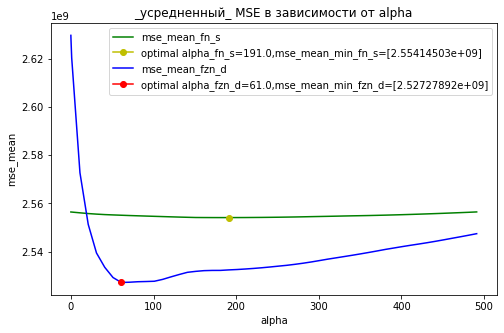

Выбранное alpha fn_s = 191.0
Выбранное alpha fzn_d = 61.0


In [169]:
optimal_alpha_fn_s = lasso_cv_fn_s.alpha_
optimal_weights_fn_s = lasso_cv_fn_s.coef_
ind, = np.where(lasso_cv_fn_s.alphas_ == lasso_cv_fn_s.alpha_)
optimal_mse_mean_fn_s = lasso_cv_fn_s.mse_path_.mean(axis=1)[ind]

optimal_alpha_fzn_d = lasso_cv_fzn_d.alpha_
optimal_weights_fzn_d = lasso_cv_fzn_d.coef_
ind, = np.where(lasso_cv_fzn_d.alphas_ == lasso_cv_fzn_d.alpha_)
optimal_mse_mean_fzn_d = lasso_cv_fzn_d.mse_path_.mean(axis=1)[ind]

plt.figure(figsize=(8, 5))

plt.plot(lasso_cv_fn_s.alphas_, lasso_cv_fn_s.mse_path_.mean(axis=1), label='mse_mean_fn_s', color='g')
plt.plot(optimal_alpha_fn_s, optimal_mse_mean_fn_s, marker='o', color='y',\
         label='optimal alpha_fn_s='+str(optimal_alpha_fn_s)+',mse_mean_min_fn_s='+str(optimal_mse_mean_fn_s))

plt.plot(lasso_cv_fzn_d.alphas_, lasso_cv_fzn_d.mse_path_.mean(axis=1), label='mse_mean_fzn_d' , color='b')
plt.plot(optimal_alpha_fzn_d, optimal_mse_mean_fzn_d, marker='o', color='r',\
         label='optimal alpha_fzn_d='+str(optimal_alpha_fzn_d)+',mse_mean_min_fzn_d='+str(optimal_mse_mean_fzn_d))

plt.title('_усредненный_ MSE в зависимости от alpha')
plt.xlabel('alpha')
plt.ylabel('mse_mean')

plt.legend(loc='upper right')
plt.show()

print('Выбранное alpha fn_s = '+str(optimal_alpha_fn_s))
print('Выбранное alpha fzn_d = '+str(optimal_alpha_fzn_d))

In [170]:
lasso_fn_s = Lasso(alpha=191, random_state=47)
lasso_fn_s.fit(X_train_fn_s, y_train_fn)
y_train_pred_fn_s = lasso_fn_s.predict(X_train_fn_s)
y_pred_fn_s = lasso_fn_s.predict(X_valid_fn_s)
r2_train = r2(y_train_fn,y_train_pred_fn_s)
mse_train = MSE(y_train_fn,y_train_pred_fn_s)
r2_valid = r2(y_valid_fn,y_pred_fn_s)
mse_valid = MSE(y_valid_fn,y_pred_fn_s)
print('lasso fn_s train: ', r2_train, mse_train)
print('lasso fn_s valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['Lasso(191)','fn_s',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])
print()
#print(*zip(features_names_fn_s, lasso_fn_s.coef_))
print()
lasso_fzn_d = Lasso(alpha=61, random_state=47)
lasso_fzn_d.fit(X_train_fzn_d, y_train_fzn)
y_train_pred_fzn_d = lasso_fzn_d.predict(X_train_fzn_d)
y_pred_fzn_d = lasso_fzn_d.predict(X_valid_fzn_d)
r2_train = r2(y_train_fzn,y_train_pred_fzn_d)
mse_train = MSE(y_train_fzn,y_train_pred_fzn_d)
r2_valid = r2(y_valid_fzn,y_pred_fzn_d)
mse_valid = MSE(y_valid_fzn,y_pred_fzn_d)
print('lasso fzn_d train: ', r2_train, mse_train)
print('lasso fzn_d valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['Lasso(61)','fzn_d',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])
print()
#print(*zip(features_names_fzn_d, lasso_fzn_d.coef_))
model_dataset

lasso fn_s train:  0.7076246504905324 2531601256.329286
lasso fn_s valid:  0.7111570246235154 2467624600.4583592


lasso fzn_d train:  0.7170505194073967 2449985136.3931694
lasso fzn_d valid:  0.7142888192947007 2440869255.0526824



,Model,Dataset,R2 train,MSE train,R2 valid,MSE valid,R2 diff
0,Lasso,fn_s,0.707781,2.530244e+09,0.710992,2.469030e+09,-0.003211
1,Lasso,fzn_d,0.731548,2.324458e+09,0.698677,2.574242e+09,0.032871
2,Lasso(191),fn_s,0.707625,2.531601e+09,0.711157,2.467625e+09,-0.003532
3,Lasso(61),fzn_d,0.717051,2.449985e+09,0.714289,2.440869e+09,0.002762


Видим, что при подборе оптимального альфа, метрика качества улучшились, но нелинейная модель RandomForest все равно дала результат лучше, даже без подбора параметров.

Так как Lasso обнуляет веса при неинформативных признаках, можем выяснить, какие признаки вносят максимальный вклад в прогноз.

In [171]:
features_weights_fn_s = pd.DataFrame()
features_weights_fn_s['feature'] = features_names_fn_s
features_weights_fn_s['Lasso_fn_s'] = lasso_fn_s.coef_
important_features_fn_s = list(features_weights_fn_s.loc[features_weights_fn_s['Lasso_fn_s']!=0, 'feature'])

features_weights_fzn_d = pd.DataFrame()
features_weights_fzn_d['feature'] = features_names_fzn_d
features_weights_fzn_d['Lasso_fzn_d'] = lasso_fzn_d.coef_
important_features_fzn_d = list(features_weights_fzn_d.loc[features_weights_fzn_d['Lasso_fzn_d']!=0, 'feature'])

print(important_features_fn_s)
print()
print(important_features_fzn_d)

['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 'Price_per_meter', 'DistrictId_size', 'Ecology_2_size', 'Shops_2_size', 'Cluster_year_size', 'District_shops_size', 'District_ecology_size']

['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price_per_meter', 'DistrictId_1', 'DistrictId_2', 'DistrictId_3', 'DistrictId_6', 'DistrictId_8', 'DistrictId_9', 'DistrictId_11', 'DistrictId_17', 'DistrictId_19', 'DistrictId_23', 'DistrictId_27', 'DistrictId_29', 'DistrictId_34', 'DistrictId_44', 'DistrictId_46', 'DistrictId_47', 'DistrictId_56', 'DistrictId_57', 'DistrictId_58', 'DistrictId_59', 'DistrictId_62', 'DistrictId_69', 'DistrictId_74', 'DistrictId_84', 'DistrictId_86', 'DistrictId_89', 'DistrictId_95', 'DistrictId_123', 'DistrictId_128', 'DistrictId_162', 'Shops_2_A', 'Cl

#### 2.2.2 Ridge - линейная регрессия с L2-регуляризацией

In [172]:
ridge_fn_s = Ridge(random_state=47)
ridge_fn_s.fit(X_train_fn_s, y_train_fn)
y_train_pred_fn_s = ridge_fn_s.predict(X_train_fn_s)
y_pred_fn_s = ridge_fn_s.predict(X_valid_fn_s)
r2_train = r2(y_train_fn,y_train_pred_fn_s)
mse_train = MSE(y_train_fn,y_train_pred_fn_s)
r2_valid = r2(y_valid_fn,y_pred_fn_s)
mse_valid = MSE(y_valid_fn,y_pred_fn_s)
print('ridge fn_s train: ', r2_train, mse_train)
print('ridge fn_s valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['Ridge','fn_s',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])
print()
ridge_fzn_d = Ridge(random_state=47)
ridge_fzn_d.fit(X_train_fzn_d, y_train_fzn)
y_train_pred_fzn_d = ridge_fzn_d.predict(X_train_fzn_d)
y_pred_fzn_d = ridge_fzn_d.predict(X_valid_fzn_d)
r2_train = r2(y_train_fzn,y_train_pred_fzn_d)
mse_train = MSE(y_train_fzn,y_train_pred_fzn_d)
r2_valid = r2(y_valid_fzn,y_pred_fzn_d)
mse_valid = MSE(y_valid_fzn,y_pred_fzn_d)
print('ridge fzn_d train: ', r2_train, mse_train)
print('ridge fzn_d valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['Ridge','fzn_d',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])
print()
print(ridge_fn_s.coef_)
model_dataset

ridge fn_s train:  0.7077813928424894 2530244065.5271206
ridge fn_s valid:  0.7110003147821495 2468963393.825878

ridge fzn_d train:  0.730929204051384 2329813256.171857
ridge fzn_d valid:  0.7022974444771628 2543313191.77818

[ 2.09594556e+04  4.98207736e+04 -5.40400299e+03  3.26639183e+03
  5.07437805e+03  7.56961970e+03  3.47968607e+02 -7.19038418e+02
  1.11713282e+03  9.02655751e+02  2.75396240e+03  6.83660749e+02
  5.40417885e+04  3.74261647e+03  9.73709476e+02  5.08053409e+01
  1.81016745e+02 -2.49584182e+03 -1.49135657e+02  1.86910361e+03
  4.38713119e+02]


,Model,Dataset,R2 train,MSE train,R2 valid,MSE valid,R2 diff
0,Lasso,fn_s,0.707781,2.530244e+09,0.710992,2.469030e+09,-0.003211
1,Lasso,fzn_d,0.731548,2.324458e+09,0.698677,2.574242e+09,0.032871
2,Lasso(191),fn_s,0.707625,2.531601e+09,0.711157,2.467625e+09,-0.003532
3,Lasso(61),fzn_d,0.717051,2.449985e+09,0.714289,2.440869e+09,0.002762
4,Ridge,fn_s,0.707781,2.530244e+09,0.711000,2.468963e+09,-0.003219
5,Ridge,fzn_d,0.730929,2.329813e+09,0.702297,2.543313e+09,0.028632


Попробуем подобрать параметр альфа для Ridge-регуляризации.

In [173]:
alphas = [0, 0.1, 0.5] + list(np.arange(1, 500, 10))

ridge_cv_fn_s = RidgeCV(cv=5, alphas=alphas)
ridge_cv_fn_s.fit(X_train_fn_s, y_train_fn)
optimal_alpha_fn_s = ridge_cv_fn_s.alpha_
print(f'optimal_alpha_fn_s={optimal_alpha_fn_s}')

ridge_cv_fzn_d = RidgeCV(cv=5, alphas=alphas)
ridge_cv_fzn_d.fit(X_train_fzn_d, y_train_fzn)
optimal_alpha_fzn_d = ridge_cv_fzn_d.alpha_
print(f'optimal_alpha_fzn_d={optimal_alpha_fzn_d}')

optimal_alpha_fn_s=11.0
optimal_alpha_fzn_d=41.0


In [174]:
ridge_fn_s = Ridge(alpha=11, random_state=47)
ridge_fn_s.fit(X_train_fn_s, y_train_fn)
y_train_pred_fn_s = ridge_fn_s.predict(X_train_fn_s)
y_pred_fn_s = ridge_fn_s.predict(X_valid_fn_s)
r2_train = r2(y_train_fn,y_train_pred_fn_s)
mse_train = MSE(y_train_fn,y_train_pred_fn_s)
r2_valid = r2(y_valid_fn,y_pred_fn_s)
mse_valid = MSE(y_valid_fn,y_pred_fn_s)
print('ridge fn_s train: ', r2_train, mse_train)
print('ridge fn_s valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['Ridge(11)','fn_s',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])
print()
ridge_fzn_d = Ridge(alpha=41, random_state=47)
ridge_fzn_d.fit(X_train_fzn_d, y_train_mn)
y_train_pred_fzn_d = ridge_fzn_d.predict(X_train_fzn_d)
y_pred_fzn_d = ridge_fzn_d.predict(X_valid_fzn_d)
r2_train = r2(y_train_fzn,y_train_pred_fzn_d)
mse_train = MSE(y_train_fzn,y_train_pred_fzn_d)
r2_valid = r2(y_valid_fzn,y_pred_fzn_d)
mse_valid = MSE(y_valid_fzn,y_pred_fzn_d)
print('ridge fzn_d train: ', r2_train, mse_train)
print('ridge fzn_d valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['Ridge(41)','fzn_d',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])
print()
print(ridge_fn_s.coef_)
model_dataset.sort_values(['R2 valid'])

ridge fn_s train:  0.7077760958700569 2530289930.618304
ridge fn_s valid:  0.7110931309615618 2468170452.6531186

ridge fzn_d train:  0.7199694099878131 2424711230.529124
ridge fzn_d valid:  0.7143935585673484 2439974453.281987

[ 2.10028600e+04  4.95192171e+04 -5.20754583e+03  3.30511164e+03
  5.08771955e+03  7.57780785e+03  3.44770477e+02 -7.64640941e+02
  1.10204702e+03  9.03120641e+02  2.76617622e+03  6.64951930e+02
  5.38288227e+04  3.61123862e+03  9.78757819e+02  4.20547593e+01
  1.92057955e+02 -2.49190003e+03 -1.47109559e+02  1.84810060e+03
  4.14269267e+02]


,Model,Dataset,R2 train,MSE train,R2 valid,MSE valid,R2 diff
1,Lasso,fzn_d,0.731548,2.324458e+09,0.698677,2.574242e+09,0.032871
5,Ridge,fzn_d,0.730929,2.329813e+09,0.702297,2.543313e+09,0.028632
0,Lasso,fn_s,0.707781,2.530244e+09,0.710992,2.469030e+09,-0.003211
4,Ridge,fn_s,0.707781,2.530244e+09,0.711000,2.468963e+09,-0.003219
6,Ridge(11),fn_s,0.707776,2.530290e+09,0.711093,2.468170e+09,-0.003317
2,Lasso(191),fn_s,0.707625,2.531601e+09,0.711157,2.467625e+09,-0.003532
3,Lasso(61),fzn_d,0.717051,2.449985e+09,0.714289,2.440869e+09,0.002762
7,Ridge(41),fzn_d,0.719969,2.424711e+09,0.714394,2.439974e+09,0.005576


Видно, что при подборе оптимального альфа, качество улучшилось.

#### 2.2.3 RandomForest - модель случайного леса

In [175]:
rf_fn_s=RF(random_state=47)
rf_fn_s.fit(X_train_fn_s, y_train_fn)
y_train_pred_fn_s = rf_fn_s.predict(X_train_fn_s)
y_pred_fn_s = rf_fn_s.predict(X_valid_fn_s)
r2_train = r2(y_train_fn,y_train_pred_fn_s)
mse_train = MSE(y_train_fn,y_train_pred_fn_s)
r2_valid = r2(y_valid_fn,y_pred_fn_s)
mse_valid = MSE(y_valid_fn,y_pred_fn_s)
print('rf fn_s train: ', r2_train, mse_train)
print('rf fn_s valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['RF','fn_s',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])

rf_fzn_d=RF(random_state=47)
rf_fzn_d.fit(X_train_fzn_d, y_train_fzn)
y_train_pred_fzn_d = rf_fzn_d.predict(X_train_fzn_d)
y_pred_fzn_d = rf_fzn_d.predict(X_valid_fzn_d)
r2_train = r2(y_train_fzn,y_train_pred_fzn_d)
mse_train = MSE(y_train_fzn,y_train_pred_fzn_d)
r2_valid = r2(y_valid_fzn,y_pred_fzn_d)
mse_valid = MSE(y_valid_fzn,y_pred_fzn_d)
print('rf fzn_d train: ', r2_train, mse_train)
print('rf fzn_d valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['RF','fzn_d',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])

model_dataset.sort_values(['R2 valid'])

rf fn_s train:  0.9548128343001457 391263783.5153966
rf fn_s valid:  0.7504107987626505 2132274299.4849262
rf fzn_d train:  0.9546082270123603 393035424.2083645
rf fzn_d valid:  0.7559109375373321 2085285870.1189408


,Model,Dataset,R2 train,MSE train,R2 valid,MSE valid,R2 diff
1,Lasso,fzn_d,0.731548,2.324458e+09,0.698677,2.574242e+09,0.032871
5,Ridge,fzn_d,0.730929,2.329813e+09,0.702297,2.543313e+09,0.028632
0,Lasso,fn_s,0.707781,2.530244e+09,0.710992,2.469030e+09,-0.003211
4,Ridge,fn_s,0.707781,2.530244e+09,0.711000,2.468963e+09,-0.003219
6,Ridge(11),fn_s,0.707776,2.530290e+09,0.711093,2.468170e+09,-0.003317
2,Lasso(191),fn_s,0.707625,2.531601e+09,0.711157,2.467625e+09,-0.003532
3,Lasso(61),fzn_d,0.717051,2.449985e+09,0.714289,2.440869e+09,0.002762
7,Ridge(41),fzn_d,0.719969,2.424711e+09,0.714394,2.439974e+09,0.005576
8,RF,fn_s,0.954813,3.912638e+08,0.750411,2.132274e+09,0.204402
9,RF,fzn_d,0.954608,3.930354e+08,0.755911,2.085286e+09,0.198697


Модель случайного леса показывает очень хорошее качество на валидационной выборке. При этом разница между метриками на тренировочной и валидационной выборках довольно большая, что говорит о переобучении. Попробуем подобрать оптимальный набор параметров, чтобы получить достойное качество, и, при этом, избежать переобучения модели.

Сначала рассмотрим параметр **n_estimators** - количество деревьев.

In [176]:
parameters = {
    'n_estimators': [5, 10, 15, 20, 30, 50, 75, 100, 300, 500],
}

clf_fn_s = GridSearchCV(
    estimator=RF(n_jobs=-1, oob_score=False, random_state=47),
    param_grid=parameters,
    scoring='r2',
    cv=5,
    return_train_score=True
)

clf_fzn_d = GridSearchCV(
    estimator=RF(n_jobs=-1, oob_score=False, random_state=47),
    param_grid=parameters,
    scoring='r2',
    cv=5,
    return_train_score=True
)

In [177]:
%%time
clf_fn_s.fit(X_train_fn_s, y_train_fn)

CPU times: user 1min 11s, sys: 10.7 s, total: 1min 22s
Wall time: 2min 42s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=47,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [5, 10, 15, 20, 30,

In [178]:
%%time
clf_fzn_d.fit(X_train_fzn_d, y_train_fzn)

CPU times: user 2min 7s, sys: 10.5 s, total: 2min 18s
Wall time: 4min 30s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=47,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [5, 10, 15, 20, 30,

In [179]:
print(clf_fn_s.best_params_)
print(clf_fzn_d.best_params_)
cv_fn_s_results = pd.DataFrame(clf_fn_s.cv_results_)
cv_fzn_d_results = pd.DataFrame(clf_fzn_d.cv_results_)
cv_fn_s_results.columns

{'n_estimators': 500}
{'n_estimators': 500}


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [180]:
param_columns = [
    column
    for column in cv_fn_s_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_fn_s_results[param_columns + score_columns])

cv_results.sort_values(['mean_test_score'], ascending=False).head(10)

,param_n_estimators,mean_test_score,mean_train_score
9,500,0.762499,0.968171
8,300,0.762109,0.968114
6,75,0.760258,0.966703
7,100,0.760243,0.967056
5,50,0.759812,0.965852
3,20,0.756462,0.961962
4,30,0.755833,0.963965
2,15,0.753164,0.959405
1,10,0.746876,0.955120
0,5,0.723043,0.941548


Text(0.5, 0, 'n_estimators')

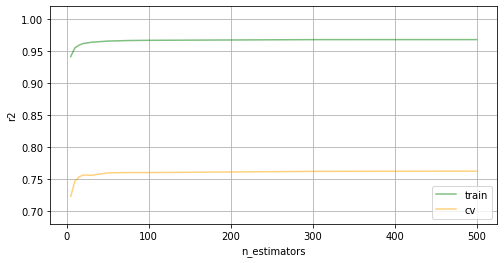

In [181]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cv_results['param_n_estimators'], cv_results['mean_train_score'], alpha=0.5, color='green', label='train')
ax.plot(cv_results['param_n_estimators'], cv_results['mean_test_score'], alpha=0.5, color='orange', label='cv')
ax.legend(loc='best')
ax.grid()
ax.set_ylim([0.68,1.02])
ax.set_ylabel('r2')
ax.set_xlabel('n_estimators')

In [182]:
param_columns = [
    column
    for column in cv_fzn_d_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_fzn_d_results[param_columns + score_columns])

cv_results.sort_values(['mean_test_score'], ascending=False).head(10)

,param_n_estimators,mean_test_score,mean_train_score
9,500,0.760409,0.967740
8,300,0.760337,0.967619
6,75,0.758719,0.966199
7,100,0.758389,0.966598
5,50,0.758001,0.965327
4,30,0.756724,0.963719
3,20,0.755514,0.961689
2,15,0.751170,0.959470
1,10,0.744180,0.955317
0,5,0.719753,0.943208


Text(0.5, 0, 'n_estimators')

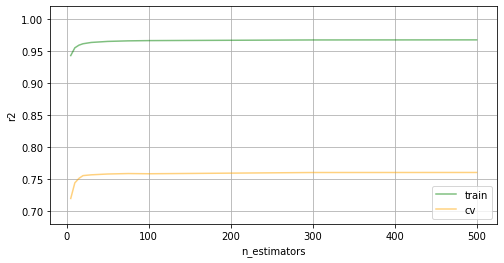

In [183]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cv_results['param_n_estimators'], cv_results['mean_train_score'], alpha=0.5, color='green', label='train')
ax.plot(cv_results['param_n_estimators'], cv_results['mean_test_score'], alpha=0.5, color='orange', label='cv')
ax.legend(loc='best')
ax.grid()
ax.set_ylim([0.68,1.02])
ax.set_ylabel('r2')
ax.set_xlabel('n_estimators')

При достижении примерно 100 деревьев доля верных ответов на валидационной выборке выходит на асимптоту - примерно 0.76. Зафиксируем параметр **n_estimators**=100.

Теперь рассмотрим параметр **max_depth** - глубина деревьев.

In [184]:
parameters = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24],
}

clf_fn_s = GridSearchCV(
    estimator=RF(n_estimators=100, n_jobs=-1, oob_score=False, random_state=47),
    param_grid=parameters,
    scoring='r2',
    cv=5,
    return_train_score=True
)

clf_fzn_d = GridSearchCV(
    estimator=RF(n_estimators=100, n_jobs=-1, oob_score=False, random_state=47),
    param_grid=parameters,
    scoring='r2',
    cv=5,
    return_train_score=True
)

In [185]:
%%time
clf_fn_s.fit(X_train_fn_s, y_train_fn)

CPU times: user 21.8 s, sys: 4.96 s, total: 26.8 s
Wall time: 1min 28s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=47,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 13, 15, 

In [186]:
%%time
clf_fzn_d.fit(X_train_fzn_d, y_train_fzn)

CPU times: user 33.4 s, sys: 5.04 s, total: 38.4 s
Wall time: 2min 49s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=47,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 13, 15, 

In [187]:
print(clf_fn_s.best_params_)
print(clf_fzn_d.best_params_)
cv_fn_s_results = pd.DataFrame(clf_fn_s.cv_results_)
cv_fzn_d_results = pd.DataFrame(clf_fzn_d.cv_results_)

{'max_depth': 11}
{'max_depth': 11}


In [188]:
param_columns = [
    column
    for column in cv_fn_s_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_fn_s_results[param_columns + score_columns])

cv_results.sort_values(['mean_test_score'], ascending=False).head(10)

,param_max_depth,mean_test_score,mean_train_score
4,11,0.764102,0.922431
5,13,0.763470,0.944667
6,15,0.762138,0.956679
3,9,0.761800,0.885957
7,17,0.760579,0.962637
10,24,0.760524,0.966919
9,22,0.760381,0.966687
8,20,0.760285,0.966105
2,7,0.755620,0.834423
1,5,0.736048,0.770094


Text(0.5, 0, 'max_depth')

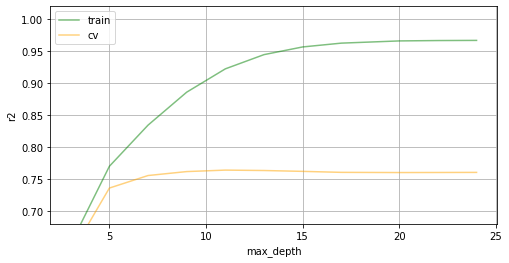

In [189]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cv_results['param_max_depth'], cv_results['mean_train_score'], alpha=0.5, color='green', label='train')
ax.plot(cv_results['param_max_depth'], cv_results['mean_test_score'], alpha=0.5, color='orange', label='cv')
ax.legend(loc='best')
ax.grid()
ax.set_ylim([0.68,1.02])
ax.set_ylabel('r2')
ax.set_xlabel('max_depth')

In [190]:
param_columns = [
    column
    for column in cv_fzn_d_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_fzn_d_results[param_columns + score_columns])

cv_results.sort_values(['mean_test_score'], ascending=False).head(10)

,param_max_depth,mean_test_score,mean_train_score
4,11,0.760345,0.917532
5,13,0.760273,0.939812
3,9,0.759730,0.882500
6,15,0.759326,0.952716
10,24,0.758634,0.966253
7,17,0.758260,0.959692
8,20,0.758105,0.964364
9,22,0.757825,0.965728
2,7,0.754361,0.833397
1,5,0.735601,0.770408


Text(0.5, 0, 'max_depth')

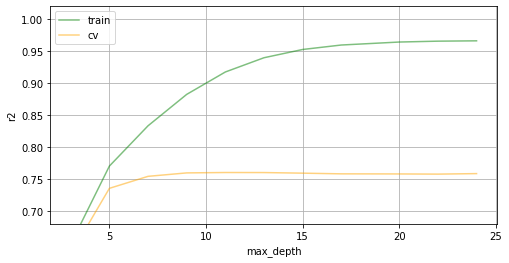

In [191]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cv_results['param_max_depth'], cv_results['mean_train_score'], alpha=0.5, color='green', label='train')
ax.plot(cv_results['param_max_depth'], cv_results['mean_test_score'], alpha=0.5, color='orange', label='cv')
ax.legend(loc='best')
ax.grid()
ax.set_ylim([0.68,1.02])
ax.set_ylabel('r2')
ax.set_xlabel('max_depth')

Оптимальное значение параметра **max_depth**=11. При данном значении качество на валидационной выборке составляет примерно 0.76, что довольно неплохо. При этом разница в качестве с тренировочной выборкой снизилась до примерно 0.15, значит выбор данного параметра помогает бороться с переобучением.

Рассмотрим параметр **min_samples_leaf** - минимальное число объектов в листе.

In [192]:
parameters = {
    'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24],
}

clf_fn_s = GridSearchCV(
    estimator=RF(n_estimators=100, max_depth=11, n_jobs=-1, oob_score=False, random_state=47),
    param_grid=parameters,
    scoring='r2',
    cv=5,
    return_train_score=True
)

clf_fzn_d = GridSearchCV(
    estimator=RF(n_estimators=100, max_depth=11, n_jobs=-1, oob_score=False, random_state=47),
    param_grid=parameters,
    scoring='r2',
    cv=5,
    return_train_score=True
)

In [193]:
%%time
clf_fn_s.fit(X_train_fn_s, y_train_fn)

CPU times: user 17.6 s, sys: 1.75 s, total: 19.4 s
Wall time: 1min 19s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=11, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=47,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20,
                             

In [194]:
%%time
clf_fzn_d.fit(X_train_fzn_d, y_train_fzn)

CPU times: user 27.7 s, sys: 2.19 s, total: 29.9 s
Wall time: 2min 27s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=11, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=47,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20,
                             

In [195]:
print(clf_fn_s.best_params_)
print(clf_fzn_d.best_params_)
cv_fn_s_results = pd.DataFrame(clf_fn_s.cv_results_)
cv_fzn_d_results = pd.DataFrame(clf_fzn_d.cv_results_)

{'min_samples_leaf': 3}
{'min_samples_leaf': 7}


In [196]:
param_columns = [
    column
    for column in cv_fn_s_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_fn_s_results[param_columns + score_columns])

cv_results.sort_values(['mean_test_score'], ascending=False).head(10)

,param_min_samples_leaf,mean_test_score,mean_train_score
1,3,0.765229,0.900837
3,7,0.765174,0.861768
2,5,0.765144,0.878864
4,9,0.764556,0.848604
5,11,0.764292,0.838332
0,1,0.764102,0.922431
6,13,0.763270,0.829165
7,15,0.761747,0.821558
8,17,0.759245,0.814584
9,20,0.756663,0.805981


Text(0.5, 0, 'min_samples_leaf')

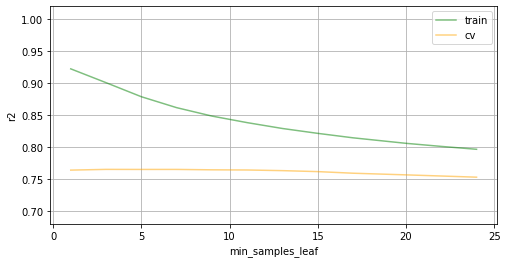

In [197]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cv_results['param_min_samples_leaf'], cv_results['mean_train_score'], alpha=0.5, color='green', label='train')
ax.plot(cv_results['param_min_samples_leaf'], cv_results['mean_test_score'], alpha=0.5, color='orange', label='cv')
ax.legend(loc='best')
ax.grid()
ax.set_ylim([0.68,1.02])
ax.set_ylabel('r2')
ax.set_xlabel('min_samples_leaf')

In [198]:
param_columns = [
    column
    for column in cv_fzn_d_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_fzn_d_results[param_columns + score_columns])

cv_results.sort_values(['mean_test_score'], ascending=False).head(10)

,param_min_samples_leaf,mean_test_score,mean_train_score
3,7,0.766304,0.861255
2,5,0.765970,0.878117
1,3,0.765636,0.899589
4,9,0.765517,0.848085
5,11,0.764986,0.837755
6,13,0.763669,0.828783
7,15,0.762291,0.821147
0,1,0.760345,0.917532
8,17,0.760010,0.814211
9,20,0.757045,0.805609


Text(0.5, 0, 'min_samples_leaf')

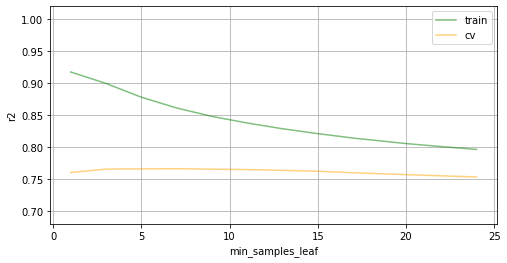

In [199]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cv_results['param_min_samples_leaf'], cv_results['mean_train_score'], alpha=0.5, color='green', label='train')
ax.plot(cv_results['param_min_samples_leaf'], cv_results['mean_test_score'], alpha=0.5, color='orange', label='cv')
ax.legend(loc='best')
ax.grid()
ax.set_ylim([0.68,1.02])
ax.set_ylabel('r2')
ax.set_xlabel('min_samples_leaf')

Оптимальные значения параметра **min_samples_leaf** 3 и 7 для датасетов **fn_s** и **fzn_d** соответственно. При этом качество на валидационной выборке осталось на уровне 0.76, а разница в качестве с тренировочной выборкой еще немного снизилась.

Рассмотрим параметр **max_features** - число признаков, по которым ищется разбиение.

In [200]:
parameters1 = {
    'max_features': [2, 4, 6, 8, 10, 11, 12, 13, 14, 16, 20],
}

parameters2 = {
    'max_features': [8, 10, 12, 14, 16, 20, 30, 40, 50, 60, 100, 150, 180, 200, 210, 220],
}

clf_fn_s = GridSearchCV(
    estimator=RF(n_estimators=100, max_depth=11, min_samples_leaf=3, n_jobs=-1, oob_score=False, random_state=47),
    param_grid=parameters1,
    scoring='r2',
    cv=5,
    return_train_score=True
)

clf_fzn_d = GridSearchCV(
    estimator=RF(n_estimators=100, max_depth=11, min_samples_leaf=7, n_jobs=-1, oob_score=False, random_state=47),
    param_grid=parameters2,
    scoring='r2',
    cv=5,
    return_train_score=True
)

In [201]:
%%time
clf_fn_s.fit(X_train_fn_s, y_train_fn)

CPU times: user 16.6 s, sys: 2.42 s, total: 19 s
Wall time: 55.5 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=11, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=3,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=47,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_features': [2, 4, 6, 8, 10, 11, 12, 13, 14, 16,
                                

In [202]:
%%time
clf_fzn_d.fit(X_train_fzn_d, y_train_fzn)

CPU times: user 27.9 s, sys: 2.59 s, total: 30.5 s
Wall time: 1min 30s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=11, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=7,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=47,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_features': [8, 10, 12, 14, 16, 20, 30, 40, 50, 60,
                             

In [203]:
print(clf_fn_s.best_params_)
print(clf_fzn_d.best_params_)
cv_fn_s_results = pd.DataFrame(clf_fn_s.cv_results_)
cv_fzn_d_results = pd.DataFrame(clf_fzn_d.cv_results_)

{'max_features': 13}
{'max_features': 180}


In [204]:
param_columns = [
    column
    for column in cv_fn_s_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_fn_s_results[param_columns + score_columns])

cv_results.sort_values(['mean_test_score'], ascending=False).head(10)

,param_max_features,mean_test_score,mean_train_score
7,13,0.770315,0.896255
5,11,0.770115,0.893990
6,12,0.770114,0.894865
9,16,0.769983,0.899006
8,14,0.769839,0.897339
4,10,0.769567,0.891867
3,8,0.768309,0.887083
10,20,0.766231,0.900838
2,6,0.763726,0.879816
1,4,0.754897,0.864486


Text(0.5, 0, 'max_features')

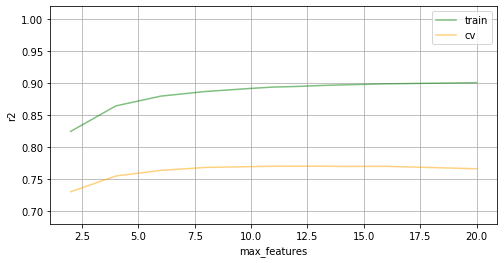

In [205]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cv_results['param_max_features'], cv_results['mean_train_score'], alpha=0.5, color='green', label='train')
ax.plot(cv_results['param_max_features'], cv_results['mean_test_score'], alpha=0.5, color='orange', label='cv')
ax.legend(loc='best')
ax.grid()
ax.set_ylim([0.68,1.02])
ax.set_ylabel('r2')
ax.set_xlabel('max_features')

In [206]:
param_columns = [
    column
    for column in cv_fzn_d_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_fzn_d_results[param_columns + score_columns])

cv_results.sort_values(['mean_test_score'], ascending=False).head(10)

,param_max_features,mean_test_score,mean_train_score
12,180,0.769552,0.857829
13,200,0.769497,0.859222
14,210,0.769208,0.859945
11,150,0.769014,0.854907
15,220,0.768592,0.860649
10,100,0.764886,0.844484
9,60,0.752933,0.825220
8,50,0.747659,0.815700
7,40,0.735519,0.801664
6,30,0.720264,0.779286


Text(0.5, 0, 'max_features')

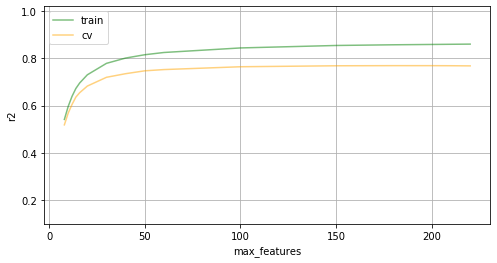

In [207]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cv_results['param_max_features'], cv_results['mean_train_score'], alpha=0.5, color='green', label='train')
ax.plot(cv_results['param_max_features'], cv_results['mean_test_score'], alpha=0.5, color='orange', label='cv')
ax.legend(loc='best')
ax.grid()
ax.set_ylim([0.10,1.02])
ax.set_ylabel('r2')
ax.set_xlabel('max_features')

Оптимальные значения параметра **max_features** 13 и 180 для датасетов **fn_s** и **fzn_d** соответственно.

Обучим модель с выбранными оптимальными параметрами и посмотрим на результаты на валидационной выборке.

In [208]:
rf_fn_s=RF(n_estimators=100, max_depth=11, min_samples_leaf=3, max_features=13, n_jobs=-1, oob_score=False, random_state=47)
rf_fn_s.fit(X_train_fn_s, y_train_fn)
y_train_pred_fn_s = rf_fn_s.predict(X_train_fn_s)
y_pred_fn_s = rf_fn_s.predict(X_valid_fn_s)
r2_train = r2(y_train_fn,y_train_pred_fn_s)
mse_train = MSE(y_train_fn,y_train_pred_fn_s)
r2_valid = r2(y_valid_fn,y_pred_fn_s)
mse_valid = MSE(y_valid_fn,y_pred_fn_s)
print('rf fn_s train: ', r2_train, mse_train)
print('rf fn_s valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['RF opt','fn_s',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])

rf_fzn_d=RF(n_estimators=100, max_depth=11, min_samples_leaf=7, max_features=180, n_jobs=-1, oob_score=False, random_state=47)
rf_fzn_d.fit(X_train_fzn_d, y_train_fzn)
y_train_pred_fzn_d = rf_fzn_d.predict(X_train_fzn_d)
y_pred_fzn_d = rf_fzn_d.predict(X_valid_fzn_d)
r2_train = r2(y_train_fzn,y_train_pred_fzn_d)
mse_train = MSE(y_train_fzn,y_train_pred_fzn_d)
r2_valid = r2(y_valid_fzn,y_pred_fzn_d)
mse_valid = MSE(y_valid_fzn,y_pred_fzn_d)
print('rf fzn_d train: ', r2_train, mse_train)
print('rf fzn_d valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['RF opt','fzn_d',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])

model_dataset.sort_values(['R2 valid'])

rf fn_s train:  0.8922674056612043 932828200.5760441
rf fn_s valid:  0.7792064738961901 1886268952.6222844
rf fzn_d train:  0.8575822949962468 1233157451.5975406
rf fzn_d valid:  0.7750098583956059 1922121206.3750684


,Model,Dataset,R2 train,MSE train,R2 valid,MSE valid,R2 diff
1,Lasso,fzn_d,0.731548,2.324458e+09,0.698677,2.574242e+09,0.032871
5,Ridge,fzn_d,0.730929,2.329813e+09,0.702297,2.543313e+09,0.028632
0,Lasso,fn_s,0.707781,2.530244e+09,0.710992,2.469030e+09,-0.003211
4,Ridge,fn_s,0.707781,2.530244e+09,0.711000,2.468963e+09,-0.003219
6,Ridge(11),fn_s,0.707776,2.530290e+09,0.711093,2.468170e+09,-0.003317
2,Lasso(191),fn_s,0.707625,2.531601e+09,0.711157,2.467625e+09,-0.003532
3,Lasso(61),fzn_d,0.717051,2.449985e+09,0.714289,2.440869e+09,0.002762
7,Ridge(41),fzn_d,0.719969,2.424711e+09,0.714394,2.439974e+09,0.005576
8,RF,fn_s,0.954813,3.912638e+08,0.750411,2.132274e+09,0.204402
9,RF,fzn_d,0.954608,3.930354e+08,0.755911,2.085286e+09,0.198697


Выяснили, что лучший результат получается на датасете **fn_s** и модели **RF(n_estimators=100, max_depth=11, min_samples_leaf=3, max_features=13, n_jobs=-1, oob_score=False, random_state=47)**.

Попробуем обучить модель на признаках, которые выявил Lasso-регуляризатор.

In [209]:
print(important_features_fn_s)
X_train_fn_s_df = pd.DataFrame(X_train_fn_s, columns=features_names_fn_s)
X_train_fn_s_li = X_train_fn_s_df[important_features_fn_s]
X_valid_fn_s_df = pd.DataFrame(X_valid_fn_s, columns=features_names_fn_s)
X_valid_fn_s_li = X_valid_fn_s_df[important_features_fn_s]

rf_fn_s_li=RF(n_estimators=100, max_depth=11, min_samples_leaf=3, max_features=13, n_jobs=-1, oob_score=False, random_state=47)
rf_fn_s_li.fit(X_train_fn_s_li, y_train_fn)
y_train_pred_fn_s_li = rf_fn_s_li.predict(X_train_fn_s_li)
y_pred_fn_s_li = rf_fn_s_li.predict(X_valid_fn_s_li)
r2_train = r2(y_train_fn,y_train_pred_fn_s_li)
mse_train = MSE(y_train_fn,y_train_pred_fn_s_li)
r2_valid = r2(y_valid_fn,y_pred_fn_s_li)
mse_valid = MSE(y_valid_fn,y_pred_fn_s_li)
print('rf fn_s li train: ', r2_train, mse_train)
print('rf fn_s li valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['RF li','fn_s',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])

model_dataset.sort_values(['R2 valid'])

['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 'Price_per_meter', 'DistrictId_size', 'Ecology_2_size', 'Shops_2_size', 'Cluster_year_size', 'District_shops_size', 'District_ecology_size']
rf fn_s li train:  0.8934424060976831 922654180.8231202
rf fn_s li valid:  0.7784048439487145 1893117385.6723766


,Model,Dataset,R2 train,MSE train,R2 valid,MSE valid,R2 diff
1,Lasso,fzn_d,0.731548,2.324458e+09,0.698677,2.574242e+09,0.032871
5,Ridge,fzn_d,0.730929,2.329813e+09,0.702297,2.543313e+09,0.028632
0,Lasso,fn_s,0.707781,2.530244e+09,0.710992,2.469030e+09,-0.003211
4,Ridge,fn_s,0.707781,2.530244e+09,0.711000,2.468963e+09,-0.003219
6,Ridge(11),fn_s,0.707776,2.530290e+09,0.711093,2.468170e+09,-0.003317
2,Lasso(191),fn_s,0.707625,2.531601e+09,0.711157,2.467625e+09,-0.003532
3,Lasso(61),fzn_d,0.717051,2.449985e+09,0.714289,2.440869e+09,0.002762
7,Ridge(41),fzn_d,0.719969,2.424711e+09,0.714394,2.439974e+09,0.005576
8,RF,fn_s,0.954813,3.912638e+08,0.750411,2.132274e+09,0.204402
9,RF,fzn_d,0.954608,3.930354e+08,0.755911,2.085286e+09,0.198697


In [210]:
print(important_features_fzn_d)
X_train_fzn_d_df = pd.DataFrame(X_train_fzn_d, columns=features_names_fzn_d)
X_train_fzn_d_li = X_train_fzn_d_df[important_features_fzn_d]
X_valid_fzn_d_df = pd.DataFrame(X_valid_fzn_d, columns=features_names_fzn_d)
X_valid_fzn_d_li = X_valid_fzn_d_df[important_features_fzn_d]

rf_fzn_d_li=RF(n_estimators=100, max_depth=11, min_samples_leaf=7, max_features=65, n_jobs=-1, oob_score=False, random_state=47)
rf_fzn_d_li.fit(X_train_fzn_d_li, y_train_fzn)
y_train_pred_fzn_d_li = rf_fzn_d_li.predict(X_train_fzn_d_li)
y_pred_fzn_d_li = rf_fzn_d_li.predict(X_valid_fzn_d_li)
r2_train = r2(y_train_fzn,y_train_pred_fzn_d_li)
mse_train = MSE(y_train_fzn,y_train_pred_fzn_d_li)
r2_valid = r2(y_valid_fzn,y_pred_fzn_d_li)
mse_valid = MSE(y_valid_fzn,y_pred_fzn_d_li)
print('rf fzn_d li train: ', r2_train, mse_train)
print('rf fzn_d li valid: ', r2_valid, mse_valid)
model_dataset = add_string_to_df(model_dataset, ['RF li','fzn_d',r2_train,mse_train,r2_valid,mse_valid,(r2_train - r2_valid)])

model_dataset.sort_values(['R2 valid'])

['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price_per_meter', 'DistrictId_1', 'DistrictId_2', 'DistrictId_3', 'DistrictId_6', 'DistrictId_8', 'DistrictId_9', 'DistrictId_11', 'DistrictId_17', 'DistrictId_19', 'DistrictId_23', 'DistrictId_27', 'DistrictId_29', 'DistrictId_34', 'DistrictId_44', 'DistrictId_46', 'DistrictId_47', 'DistrictId_56', 'DistrictId_57', 'DistrictId_58', 'DistrictId_59', 'DistrictId_62', 'DistrictId_69', 'DistrictId_74', 'DistrictId_84', 'DistrictId_86', 'DistrictId_89', 'DistrictId_95', 'DistrictId_123', 'DistrictId_128', 'DistrictId_162', 'Shops_2_A', 'Cluster_year_0', 'Cluster_year_1', 'Cluster_year_2', 'Cluster_year_3', 'Cluster_year_5', 'Cluster_year_6', 'District_social_0', 'District_social_1', 'District_social_2', 'District_social_3', 'District_shops_0', 'District_shops_1', 'District_shops_2', 'District_shops_3', 'District_shops_4', 'Di

,Model,Dataset,R2 train,MSE train,R2 valid,MSE valid,R2 diff
1,Lasso,fzn_d,0.731548,2.324458e+09,0.698677,2.574242e+09,0.032871
5,Ridge,fzn_d,0.730929,2.329813e+09,0.702297,2.543313e+09,0.028632
0,Lasso,fn_s,0.707781,2.530244e+09,0.710992,2.469030e+09,-0.003211
4,Ridge,fn_s,0.707781,2.530244e+09,0.711000,2.468963e+09,-0.003219
6,Ridge(11),fn_s,0.707776,2.530290e+09,0.711093,2.468170e+09,-0.003317
2,Lasso(191),fn_s,0.707625,2.531601e+09,0.711157,2.467625e+09,-0.003532
3,Lasso(61),fzn_d,0.717051,2.449985e+09,0.714289,2.440869e+09,0.002762
7,Ridge(41),fzn_d,0.719969,2.424711e+09,0.714394,2.439974e+09,0.005576
8,RF,fn_s,0.954813,3.912638e+08,0.750411,2.132274e+09,0.204402
9,RF,fzn_d,0.954608,3.930354e+08,0.755911,2.085286e+09,0.198697


При таком отборе признаков результат лучше не стал.

## Шаг 3: Предсказание результатов на основе выбранной модели

Выбранная модель **RF(n_estimators=100, max_depth=11, min_samples_leaf=3, max_features=13, n_jobs=-1, oob_score=False, random_state=47)**,
выбранный датасет **fn_s**.

Датасет для предсказания **test_fn_full_s**

Соберем тренировочный и валидационный датасеты в один, чтобы обучить выбранную модель на полном наборе данных.

In [211]:
print(X_train_fn_s.shape, y_train_fn.shape)
print(X_valid_fn_s.shape, y_valid_fn.shape)
print(test_fn_full_s.shape)

(7000, 21) (7000,)
(3000, 21) (3000,)
(5000, 21)


In [212]:
X_train_final = np.vstack((X_train_fn_s, X_valid_fn_s))
y_train_fn_df = pd.DataFrame(y_train_fn, columns=['Price'])
y_valid_fn_df = pd.DataFrame(y_valid_fn, columns=['Price'])
y_train_final = np.vstack((y_train_fn_df, y_valid_fn_df))

print(X_train_final.shape, y_train_final.shape)
train_final_full = pd.DataFrame(X_train_final, columns=features_names_fn_s)
train_final = train_final_full.copy()
train_final.info()

(10000, 21) (10000, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
Rooms                    10000 non-null float64
Square                   10000 non-null float64
LifeSquare               10000 non-null float64
KitchenSquare            10000 non-null float64
Floor                    10000 non-null float64
HouseFloor               10000 non-null float64
HouseYear                10000 non-null float64
Ecology_1                10000 non-null float64
Social_1                 10000 non-null float64
Social_3                 10000 non-null float64
Helthcare_2              10000 non-null float64
Shops_1                  10000 non-null float64
Price_per_meter          10000 non-null float64
DistrictId_size          10000 non-null float64
Ecology_2_size           10000 non-null float64
Ecology_3_size           10000 non-null float64
Shops_2_size             10000 non-null float64
Cluster_year_size        10000 non-null float64
Distr

К тестовому датасету добавим столбец Id, который мы удалили ранее при обработке категориальных признаков.

In [213]:
test_ids = pd.DataFrame(test_ids, columns=['Id'])
test_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 1 columns):
Id    5000 non-null int64
dtypes: int64(1)
memory usage: 78.1 KB


In [214]:
X_test_final = np.hstack((test_ids, test_fn_full_s))
features_names_fn_s_with_id = ['Id'] + features_names_fn_s
test_final_full = pd.DataFrame(X_test_final, columns=features_names_fn_s_with_id)
test_final_full['Id'] = test_final_full['Id'].astype('int64')
test_final = test_final_full.drop(['Id'],axis=1)
test_final_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
Id                       5000 non-null int64
Rooms                    5000 non-null float64
Square                   5000 non-null float64
LifeSquare               5000 non-null float64
KitchenSquare            5000 non-null float64
Floor                    5000 non-null float64
HouseFloor               5000 non-null float64
HouseYear                5000 non-null float64
Ecology_1                5000 non-null float64
Social_1                 5000 non-null float64
Social_3                 5000 non-null float64
Helthcare_2              5000 non-null float64
Shops_1                  5000 non-null float64
Price_per_meter          5000 non-null float64
DistrictId_size          5000 non-null float64
Ecology_2_size           5000 non-null float64
Ecology_3_size           5000 non-null float64
Shops_2_size             5000 non-null float64
Cluster_year_size        5000 non-null float64
Di

In [215]:
print(train_final.shape, y_train_final.shape)
y_train_final = pd.DataFrame(y_train_final, columns=['Price'])

(10000, 21) (10000, 1)


Скорректируем параметр **n_estimators** модели под новую выборку.

In [216]:
parameters = {
    'n_estimators': [50, 75, 100, 300, 500],
}

clf = GridSearchCV(
    estimator=RF(max_depth=11, min_samples_leaf=3, max_features=13, n_jobs=-1, oob_score=False, random_state=47),
    param_grid=parameters,
    scoring='r2',
    cv=5,
    return_train_score=True
)

In [217]:
%%time
clf.fit(train_final, y_train_final)

CPU times: user 28.3 s, sys: 2.64 s, total: 30.9 s
Wall time: 1min 14s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=11, max_features=13,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=3,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=47,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [50, 75, 100, 300, 500]},
             pre_dispatch='2*n_jobs', refit=

In [218]:
print(clf.best_params_)
cv_results = pd.DataFrame(clf.cv_results_)

{'n_estimators': 300}


In [219]:
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_results[param_columns + score_columns])

cv_results.sort_values(['mean_test_score'], ascending=False).head(10)

,param_n_estimators,mean_test_score,mean_train_score
3,300,0.778816,0.890851
4,500,0.778757,0.890963
2,100,0.777917,0.890658
0,50,0.777574,0.889771
1,75,0.777096,0.890503


Text(0.5, 0, 'n_estimators')

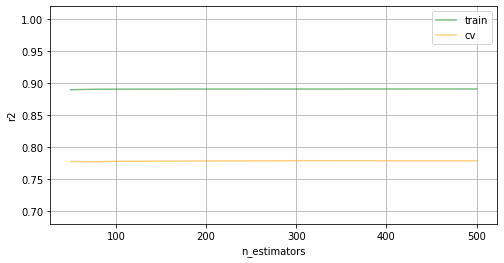

In [220]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cv_results['param_n_estimators'], cv_results['mean_train_score'], alpha=0.5, color='green', label='train')
ax.plot(cv_results['param_n_estimators'], cv_results['mean_test_score'], alpha=0.5, color='orange', label='cv')
ax.legend(loc='best')
ax.grid()
ax.set_ylim([0.68,1.02])
ax.set_ylabel('r2')
ax.set_xlabel('n_estimators')

In [221]:
model = RF(n_estimators=300, max_depth=11, min_samples_leaf=3, max_features=13, n_jobs=-1, oob_score=False, random_state=47)

In [222]:
model.fit(train_final, y_train_final)
y_train_pred_final = model.predict(train_final)
test_final_full['Price'] = model.predict(test_final)
r2_train = r2(y_train_final,y_train_pred_final)
mse_train = MSE(y_train_final,y_train_pred_final)
print('rf fn_s train: ', r2_train, mse_train)

rf fn_s train:  0.886105046484018 982275687.3848639


In [223]:
test_final_full.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Price_per_meter,DistrictId_size,Ecology_2_size,Ecology_3_size,Shops_2_size,Cluster_year_size,District_social_size,District_shops_size,District_ecology_size,Price
0,725,0.139932,-0.334130,-0.157715,0.064293,-0.482113,0.092604,-0.698824,1.607652,-0.780698,...,-0.932399,-0.226433,0.09897,0.16816,0.299864,0.301019,0.569158,0.375640,-1.029063,155754.118034
1,15856,0.139932,0.679467,0.265540,-1.186051,-0.482113,-1.220226,-0.427253,-0.361948,-1.065895,...,-0.616754,-0.465409,0.09897,0.16816,0.299864,-0.781405,0.569158,0.375640,0.061388,222496.078616
2,5480,-1.094034,-2.108891,-1.223113,1.564705,-1.245343,-1.384330,-4.120627,-0.998641,0.303050,...,0.000000,-0.882988,0.09897,0.16816,0.299864,-1.307419,-0.787552,-1.490070,-1.941374,131022.825628
3,15664,0.139932,0.877339,0.970050,0.814499,2.570806,1.405433,1.202177,-0.142708,-0.096225,...,-0.057117,-0.538360,0.09897,0.16816,0.299864,-1.141932,0.852052,0.375640,0.061388,302283.103321
4,14275,-1.094034,-0.457324,0.448867,-1.186051,1.616769,0.584915,1.745320,-0.392373,-1.294053,...,-1.000264,2.218668,0.09897,0.16816,-3.334848,-0.300140,0.569158,1.166175,1.162273,140891.982053


In [224]:
test_final_full.loc[:,['Id','Price']].to_csv('ASmelova_predictions.csv',index=False)

In [225]:
pd.read_csv('ASmelova_predictions.csv')

,Id,Price
0,725,155754.118034
1,15856,222496.078616
2,5480,131022.825628
3,15664,302283.103321
4,14275,140891.982053
5,7633,206272.270896
6,13329,168996.352497
7,5502,219930.611938
8,4220,304394.957970
9,11538,211989.875302
